# Basic Machine Learning for Predicting Thunderstorm Rotation
This module uses basic ML models – linear regression, logistic regression, decision trees, random forests, and gradient-boosted trees – to predict future rotation in numerically simulated thunderstorms from the National Center for Atmospheric Research (NCAR) convection-allowing ensemble (Schwartz et al. 2015).

# Setup

To use this notebook, you will need Python 3.6 and the following packages.

 - scipy
 - TensorFlow
 - Keras
 - scikit-image
 - netCDF4
 - pyproj
 - scikit-learn
 - opencv-python
 - matplotlib
 - shapely
 - geopy
 - metpy
 - descartes

If you have Anaconda on a Linux or Mac, you can install these packages with the commands `pip install scipy`, `pip install tensorflow`, etc.

# Imports

The next cell imports all libraries that will be used by this notebook.  If the notebook crashes anywhere, it will probably be here.

In [1]:
%matplotlib inline
import copy
import warnings
import numpy
import matplotlib.pyplot as pyplot
import utils
import roc_curves
import attr_diagrams  


warnings.filterwarnings('ignore')
DEFAULT_FEATURE_DIR_NAME = ('./data/track_data_ncar_ams_3km_csv_small')
SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

MODULE2_DIR_NAME = '.'
SHORT_COURSE_DIR_NAME = '..'

### Find input data

Find the input data based on their directory, and categorized them based on training (2010-2014), validation (2015) and testing (2016-2017) periods. 

In [2]:
training_file_names = utils.find_many_feature_files(
    first_date_string='20100101', last_date_string='20141231', feature_dir_name=DEFAULT_FEATURE_DIR_NAME)

validation_file_names = utils.find_many_feature_files(
    first_date_string='20150101', last_date_string='20151231', feature_dir_name=DEFAULT_FEATURE_DIR_NAME)

testing_file_names = utils.find_many_feature_files(
    first_date_string='20160101', last_date_string='20171231', feature_dir_name=DEFAULT_FEATURE_DIR_NAME)

### Read Data

Next step is reading the data, and explore the contents of the files. 

In [3]:
(training_metadata_table, training_predictor_table_denorm,
 training_target_table
) = utils.read_many_feature_files(training_file_names)
print(MINOR_SEPARATOR_STRING)

(validation_metadata_table, validation_predictor_table_denorm,
 validation_target_table
) = utils.read_many_feature_files(validation_file_names)
print(MINOR_SEPARATOR_STRING)

(testing_metadata_table, testing_predictor_table_denorm,
 testing_target_table
) = utils.read_many_feature_files(testing_file_names)
print(MINOR_SEPARATOR_STRING)

print('Variables in metadata are as follows:\n{0:s}'.format(
    str(list(training_metadata_table))
))

print('\nPredictor variables are as follows:\n{0:s}'.format(
    str(list(training_predictor_table_denorm))
))

print('\nTarget variable is as follows:\n{0:s}'.format(
    str(list(training_target_table))
))

first_predictor_name = list(training_predictor_table_denorm)[0]
these_predictor_values = (
    training_predictor_table_denorm[first_predictor_name].values[:10]
)

message_string = (
    '\nValues of predictor variable "{0:s}" for the first training '
    'examples:\n{1:s}'
).format(first_predictor_name, str(these_predictor_values))
print(message_string)

target_name = list(training_target_table)[0]
these_target_values = training_target_table[target_name].values[:10]

message_string = (
    '\nValues of target variable for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)


Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: "./data/t

Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20150712-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20151031-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20151227-0000.csv"...


--------------------------------------------------


Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20160224-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20160323-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20160401-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20160415-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20160429-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM

In [4]:
training_predictor_table_denorm.head(5)

,REFL_COM_mean,REFL_COM_max,REFL_COM_min,REFL_COM_std,REFL_COM_percentile_10,REFL_COM_percentile_25,REFL_COM_percentile_50,REFL_COM_percentile_75,REFL_COM_percentile_90,U10_mean,...,T2_percentile_10,T2_percentile_25,T2_percentile_50,T2_percentile_75,T2_percentile_90,area,eccentricity,major_axis_length,minor_axis_length,orientation
0,42.71822,43.67072,40.97010,0.96199,41.41314,41.91508,42.97249,43.62384,43.63801,0.19710,...,293.05662,293.12073,293.17340,293.20276,293.21045,9,0.78628,4.27766,2.64302,-0.10555
1,47.09285,54.19151,40.63351,3.34380,43.27050,44.62197,46.86275,49.64786,51.59267,-1.03154,...,291.81573,291.87878,291.98325,292.14569,292.21041,35,0.47108,7.07588,6.24158,-1.33266
2,45.53852,48.22308,40.77723,1.97809,42.59812,44.32117,45.83910,47.22936,47.66140,-0.21393,...,292.61641,292.71604,293.00183,293.26897,293.48459,36,0.87636,9.90123,4.76900,-0.10405
3,44.30976,47.98366,41.44846,1.61085,42.41405,43.40802,43.90155,45.34798,46.96363,1.27862,...,292.12880,292.26558,292.66022,292.91397,293.20261,39,0.97896,16.76704,3.42129,-0.71430
4,44.64383,50.23818,41.77694,2.45656,42.25287,42.95226,43.55742,45.76885,48.53609,0.88129,...,292.13662,292.20366,292.27325,292.39474,292.60328,23,0.94226,9.77854,3.27479,-0.91437


In [5]:
training_target_table.head(5)

,RVORT1_MAX-future_max
0,0.00035
1,0.00195
2,0.00241
3,0.00233
4,0.00254


### Normalization

When you have multiple predictor variables on different scales, they should be normalized.
This ensures that the model does not ignore variables with smaller scales.
For example, if a model is trained with temperature in Kelvins and specific humidity in kg kg$^{-1}$, it will probably learn to emphasize temperature (which varies from $\sim$180-330 K) and ignore specific humidity (which varies from $\sim$0-0.02 kg kg$^{-1}$).

**The sklearn.preprocessing package provide several common utility functions to standardize the raw input predctors:**

\url(https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).


*   **MinMaxScaler**: 

Scaling features to lie between a given minimum and maximum value, often between zero and one.

*   **MaxAbsScaler**:

scaling features to in a way that the maximum absolute value of each feature is scaled to unit size. The motivation to use the scaling normalization methds is being rebust to very small standard deviations of features and preserving zero entires in sparse data. 
*   **StandardScaler**:

implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set.
*   **RobustScaler**:

If your data contains many outliers, scaling using the mean and variance of the data is likely to not work very well. In these cases, you can use robust_scale and RobustScaler as drop-in replacements instead. They use more robust estimates for the center and range of your data.
*   **Normalizer**:

Normalization is the process of scaling individual samples to have unit norm. 
*   **QuantileTransformer**:

Two types of transformations are available: quantile transforms and power transforms. Both quantile and power transforms are based on monotonic transformations of the features and thus preserve the rank of the values along each feature. a quantile transform smooths out unusual distributions and is less influenced by outliers than scaling methods. It does, however, distort correlations and distances within and across features.
*   **PowerTransformer**:

Power transforms are a family of parametric transformations that aim to map data from any distribution to as close to a Gaussian distribution.


**Each predictor variable is transformed independently to sclaed data, using the mean and standard deviation from the training data. Validation and testing data should also be normalized, but using the means and standard deviations from the training data.**

### Normalization Code
The next cell does the following:
Finds normalization parameters (mean and standard deviation) for each predictor, based only on the training data and perform it for validation and test data. 

In [6]:
training_predictor_table, validation_predictor_table, testing_predictor_table = utils.norm_predictors(
    training_predictor_table_denorm,validation_predictor_table_denorm, testing_predictor_table_denorm, "StandardScaler")

predictor_names = list(training_predictor_table_denorm)

original_values = (
    'Original values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(training_predictor_table_denorm[predictor_names[0]].values[:10]))
print(original_values) 

normalized_values = (
    '\nNormalized values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(training_predictor_table[predictor_names[0]].values[:10]))
print(normalized_values)


Original values of "REFL_COM_mean" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]

Normalized values of "REFL_COM_mean" for the first training examples:
[-1.03620187  0.06183004 -0.32830671 -0.63672541 -0.55287385 -0.62955936
 -0.27959515 -0.79200151 -0.36799482  0.11659572]


#======================================================================================================================#
# Linear Regression 

Generally, a linear model makes a prediction by simply computing a **weighted sum** of the input features, plus a constant called the **bias term** (also called the intercept term), as shown in following equation: 

$\hat{y} (\theta, x) = \theta_0 + \theta_1 x_1 + ...+ \theta_n x_n$ 
$=\theta_0 + \sum\limits_{j = 1}^{N} \theta_j x_j$


 - $\hat{y}$ = is the predicted value (in this case, max future vorticity within storm, in s$^{-1}$)
 - $N$ = number of predictor variables
 - $x_j$ = $j^{\textrm{th}}$ predictor variable
 - $\theta_j$ = coefficient for $j^{\textrm{th}}$ predictor variable (adjusted during training)
 - $\theta_0$ = bias coefficient or "intercept" (adjusted during training)

That is the **Linear Regression Model** which need to be trained!? Recall that training a model means setting its parameters so that the model best fits the training set. The most common performance measure of a regression model is the Root Mean Square Error (RMSE). Therefore, to train a Linear Regression model, you need to find the value of **$\theta$** that minimize the **RMSE**. In practice, it is simpler to minimize the Mean Square Error than RMSE, and it leads to the same result. 

$MSE(\theta) = \frac{1}{M} \sum\limits_{i = 1}^{M} (\hat{y}_i - y_i)^2$ 

 - $y_i$ = actual target value for $i^{\textrm{th}}$ example (in this case, one example is one storm cell at one time, or one "storm object")
 - $\hat{y}_i$ = predicted target value for $i^{\textrm{th}}$ example
 - $M$ = number of training examples
 
 
 
 There is a **closed-form** solution to find the value of $\theta$ to minimize the cost function, a mathematical equation: 
 
 $\hat{\theta} = (X^{T}.X)^{-1}.X^{T}.y$
 
 - $\hat{\theta}$ is the value of $\theta$ that minimize the cost function. 
 - y is the vector of target values containing $y^{(1)}$ to $y^{(m)}$
 
 
 Also, **Gradient descent** is a very generic optimization algorithm capable of finding optimal solution to wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimiez a cost function. To implement Gradine Desent you need to compute the gradient of the cost function with regards to each model parameter $\theta_j$. In other words, you need to calculate how much the cost function will change if you change $\theta_j$ just a little bit (called a partial derivative). The partial derivative of the cost function with regards to parameter $\theta_j$, notes $\frac{\partial}{\partial \theta_j}\textrm{MSE}(\theta)$: 
 
$\frac{\partial}{\partial \theta_j}(\textrm{MSE}) = \frac{2}{M} \sum\limits_{i = 1}^{M} x_{ij} (\hat{y}_i - y_i)$

once you have the gradient over each iterations and adjusted weights, the **learning rate $\eta$** comes into play, multiply the gradinet vector by $\eta$ to determine the size of gradinet step, it is $\in \left(0, 1\right]$. 

$\theta_0 \leftarrow \theta_0 - \eta \frac{\partial}{\partial \theta_0}(\textrm{MSE})$
<br>
$\theta_j \leftarrow \theta_j - \eta \frac{\partial}{\partial \theta_j}(\textrm{MSE})$


### Important points: 
- when using Gradient Descent, you should ensure that all features have a similar scale, or else it will take much more longer to converge.
- If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time. on the other hand, if the learning rate is too high, you might jump across the local minimum and failing to find a good solution.  


### Point
The coefficient estimates for Ordinary Least Squares rely on the independence of the features. When features are correlated and the columns of the design matrix  have an approximate linear dependence, the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed target, producing a large variance. This situation of **multicollinearity** can arise, for example, when data are collected without an experimental design.

The least square solution is computed using the singular value decomposition of X. if X is a matrix of shape (n_sample, n_features) this method has a cost of $O(n_{sample}n_{features}^{2})$, assuming that $n_{samples} >> n_{features}$

# Linear Regression Evaluation metrics:


**For both training and validation data, this cell reports the following quantities:**

 - Mean absolute error (MAE): $\frac{1}{N} \sum\limits_{i = 1}^{N} \lvert \hat{y}_i - y_i \rvert$
 - Mean squared error (MSE): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$
 - Mean signed error ("bias"): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$
 - MAE skill score.  This is defined as follows, where MAE is the MAE of the model and $\textrm{MAE}_{\textrm{climo}}$ is the MAE obtained by always predicting "climatology" (the average in the training data).

$\textrm{MAE skill score} = \frac{\textrm{MAE}_{\textrm{climo}} - \textrm{MAE}}{\textrm{MAE}_{\textrm{climo}}}$

 - MSE skill score, defined as follows.

$\textrm{MSE skill score} = \frac{\textrm{MSE}_{\textrm{climo}} - \textrm{MSE}}{\textrm{MSE}_{\textrm{climo}}}$

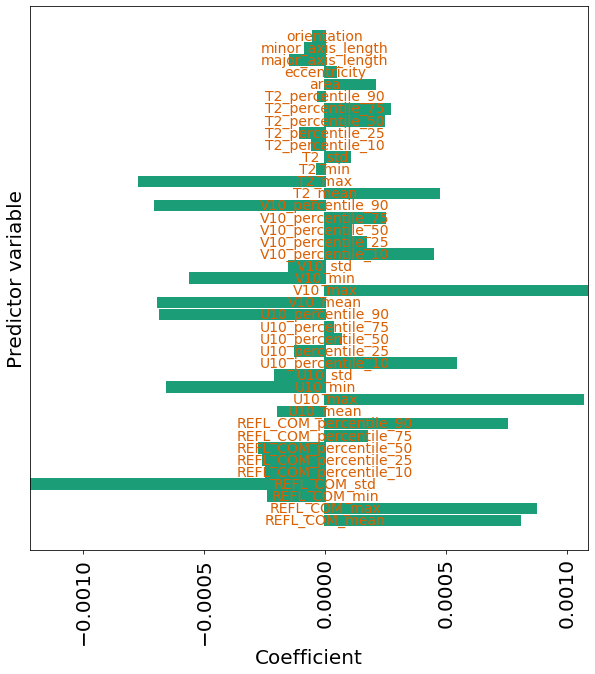

The results for Training samples: 
Training MAE (mean absolute error) = 7.714e-04 s^-1
Training MSE (mean squared error) = 1.112e-06 s^-2
Training bias (mean signed error) = 1.813e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


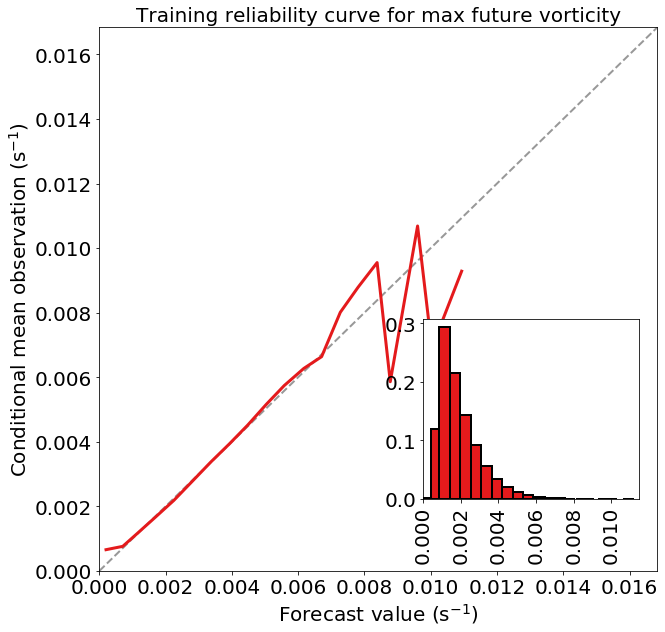



--------------------------------------------------


The results for Validation samples: 
Validation MAE (mean absolute error) = 7.505e-04 s^-1
Validation MSE (mean squared error) = 1.048e-06 s^-2
Validation bias (mean signed error) = -9.007e-07 s^-1
Validation MAE skill score (improvement over climatology) = 0.316
Validation MSE skill score (improvement over climatology) = 0.540


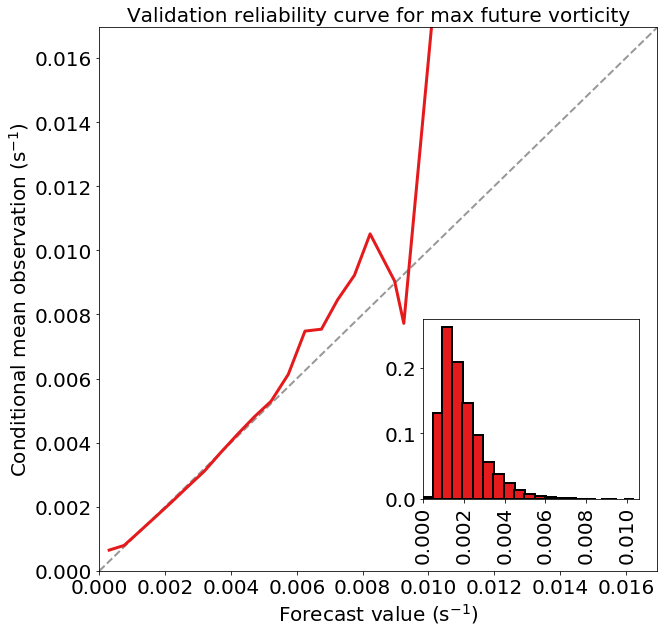



--------------------------------------------------


The results for Testing samples: 
Testing MAE (mean absolute error) = 8.257e-04 s^-1
Testing MSE (mean squared error) = 1.410e-06 s^-2
Testing bias (mean signed error) = -8.930e-05 s^-1
Testing MAE skill score (improvement over climatology) = 0.338
Testing MSE skill score (improvement over climatology) = 0.556


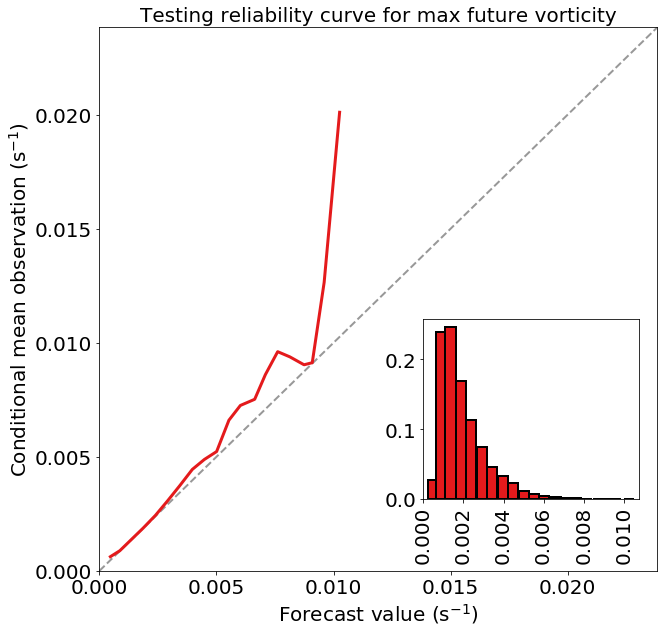

In [7]:
# calculating the mean of target values: 
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values)
mean_validation_target_value = numpy.mean(
    validation_target_table[utils.TARGET_NAME].values)
mean_test_target_value = numpy.mean(
    testing_target_table[utils.TARGET_NAME].values)


# setup the linear funciton: 
linreg_model_ordinary = utils.ordinary_linear_regression()

# Training: 
_ = utils.train_linear_regression(
    model_object=linreg_model_ordinary,
    training_predictor_table = training_predictor_table,
    training_target_table = training_target_table)

# predict on training samples: 
training_predictions_ordinary = linreg_model_ordinary.predict(
    training_predictor_table.as_matrix()
)

utils.plot_model_coefficients(
    model_object=linreg_model_ordinary,
    predictor_names=list(training_predictor_table)
)
pyplot.show()

print("The results for Training samples: ")
# Evaluate on training samples: 
_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions_ordinary,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

#=====================================================================================
# predict on validation samples: 
print("The results for Validation samples: ")
validation_predictions_ordinary = linreg_model_ordinary.predict(
    validation_predictor_table.as_matrix()
)
# Evaluation of validation  samples:
_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions_ordinary,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')
print(MINOR_SEPARATOR_STRING)
#=====================================================================================
# predict of test samples:
print("The results for Testing samples: ")
test_prediction_ordinary = linreg_model_ordinary.predict(
    testing_predictor_table.as_matrix()
)

# Evaluation of test samples: 
_ = utils.evaluate_regression(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    predicted_target_values=test_prediction_ordinary,
    mean_training_target_value=mean_training_target_value,
    dataset_name='Testing')


# $L_1$ and $L_2$ Regularization

 - In general, **regularization is a way to prevent overfitting by creating a simpler model.**
 - $L_1$ and $L_2$ regularization encourage the model to have smaller coefficients.
<br><br>
 - **This is useful when there are many predictors**, because it is likely that some of these predictors have a weak causal relationship with the phenomenon.
 - Without regularization the model will try to incorporate every predictor, which may lead to overfitting peculiarities of the training data.
 - Regularization encourages the model to learn large coefficients for only a small number of predictors (the **really** important ones).
<br><br>
 - **$L_1$ and $L_2$ regularization encourage smaller coefficients by adding penalties to the loss function.**
 - For linear regression, the loss function turns into the following.

$\epsilon = \frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2 + \lambda_1 \sum\limits_{j = 1}^{M} \lvert \beta_j \rvert + \lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2 = \textrm{MSE} + \lambda_1 \sum\limits_{j = 1}^{M} \lvert \beta_j \rvert + \lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2$

 - The first term is just MSE (mean squared error).
 - The second term is the $L_1$ penalty.  $\lambda_1$ is the strength of the $L_1$ penalty, and $\sum\limits_{j = 1}^{M} \lvert \beta_j \rvert$ is the sum of absolute coefficient values.
 - The third term is the $L_2$ penalty.  $\lambda_2$ is the strength of the $L_2$ penalty, and $\lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2$ is the sum of squared coefficient values.
<br><br>
 - Both penalties encourage smaller coefficients, but the $L_1$ penalty also encourages fewer non-zero coefficients.
 - This is because the $L_1$ penalty does not square coefficient values.
 - For small coefficient values the $L_2$ penalty becomes negligible unless $L_2$ is very large.  For example, squaring a coefficient of $10^{-3}$ yields $10^{-6}$, and this penalty is usually negligible.
<br><br>
 - For this reason the $L_1$ penalty is called the **"lasso penalty"** (it throws a lasso and keeps only the predictors inside the lasso).
 - The $L_2$ penalty is called the **"ridge penalty"**.
 - Whereas $L_1$ only is called the "lasso penalty" and $L_2$ only is called the "ridge penalty," this is called the **"elastic net"**.

### Ridge Linear regression 

The best alpha:  1.4677992676220735


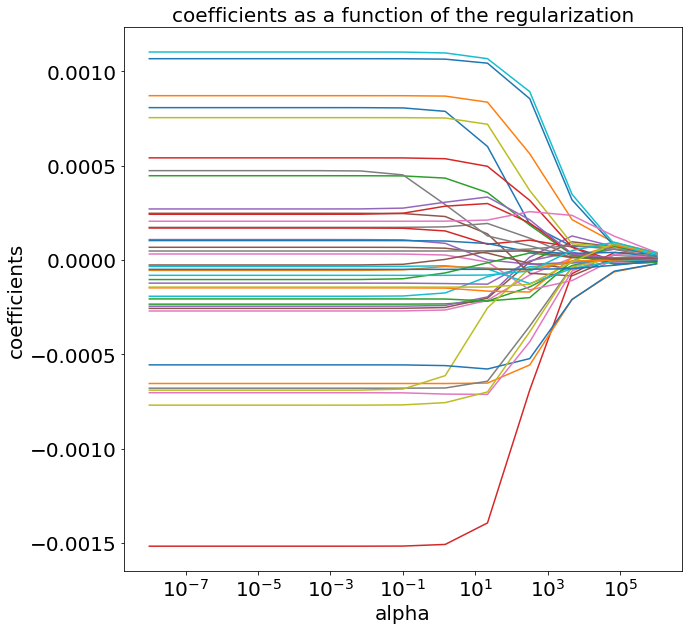



--------------------------------------------------




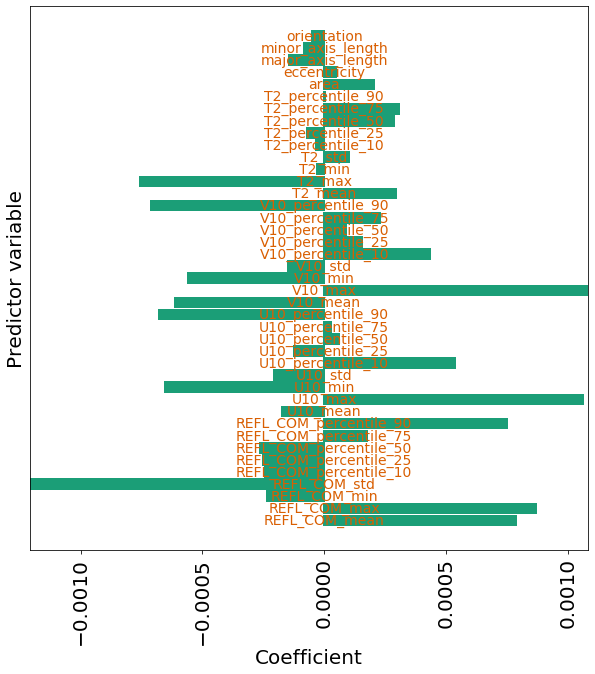



--------------------------------------------------


The results for Training samples: 
Training MAE (mean absolute error) = 7.714e-04 s^-1
Training MSE (mean squared error) = 1.112e-06 s^-2
Training bias (mean signed error) = 2.253e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


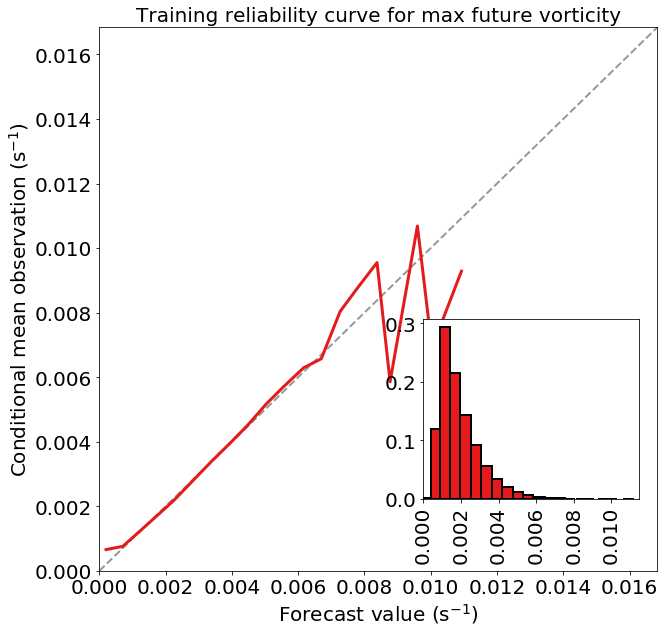



--------------------------------------------------


The results for Validation samples: 
Validation MAE (mean absolute error) = 7.505e-04 s^-1
Validation MSE (mean squared error) = 1.049e-06 s^-2
Validation bias (mean signed error) = -8.884e-07 s^-1
Validation MAE skill score (improvement over climatology) = 0.316
Validation MSE skill score (improvement over climatology) = 0.540


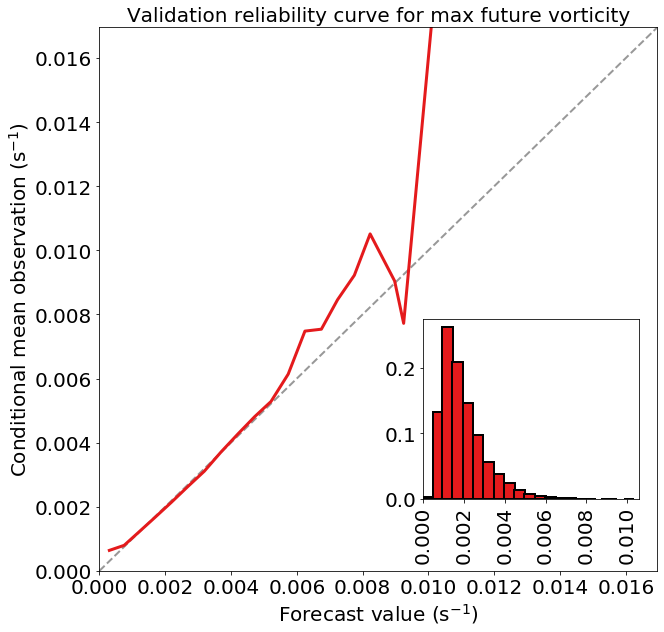



--------------------------------------------------


The results for Test samples: 
Testing MAE (mean absolute error) = 8.257e-04 s^-1
Testing MSE (mean squared error) = 1.410e-06 s^-2
Testing bias (mean signed error) = -8.933e-05 s^-1
Testing MAE skill score (improvement over climatology) = 0.338
Testing MSE skill score (improvement over climatology) = 0.556


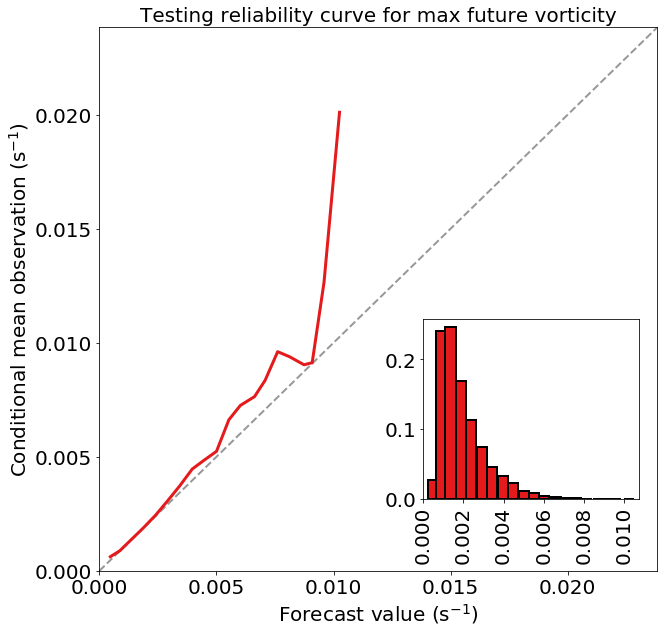

In [8]:
# calculating the mean of target values: 
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values)
mean_validation_target_value = numpy.mean(
    validation_target_table[utils.TARGET_NAME].values)
mean_test_target_value = numpy.mean(
    testing_target_table[utils.TARGET_NAME].values)


n_alphas = 13
L2 = numpy.logspace(-8, 6, n_alphas)
cv = 5

# setup the linear funciton: 
linreg_regularized_model_ridge = utils.Ridge_Lasso_linreg(
    model_type = "Ridge", alphas = L2, cv = cv)

# Training: 
reg = utils.train_linear_regression(
    model_object=linreg_regularized_model_ridge,
    training_predictor_table = training_predictor_table,
    training_target_table = training_target_table)

print("The best alpha: ", reg.alpha_)
utils.plot_find_best_alpha(training_predictor_table, training_target_table, alphas = L2, flag = 1) 
print(MINOR_SEPARATOR_STRING)

utils.plot_model_coefficients(
    model_object=linreg_regularized_model_ridge,
    predictor_names=list(training_predictor_table)
)
pyplot.show()

print(MINOR_SEPARATOR_STRING)
# predict of training samples: 
training_predictions_ridge = linreg_regularized_model_ridge.predict(
    training_predictor_table.as_matrix()
)

print("The results for Training samples: ")
# Evaluate the training samples: 
_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions_ridge,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

#=====================================================================================
# predict of validation samples: 
print("The results for Validation samples: ")
validation_predictions_ridge = linreg_regularized_model_ridge.predict(
    validation_predictor_table.as_matrix()
)
# Evaluation of validation  samples:
_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions_ridge,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')
print(MINOR_SEPARATOR_STRING)
#=====================================================================================
# predict of test samples:
print("The results for Test samples: ")
test_predictions_ridge = linreg_regularized_model_ridge.predict(
    testing_predictor_table.as_matrix()
)

# Evaluation of test samples: 
_ = utils.evaluate_regression(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    predicted_target_values=test_predictions_ridge,
    mean_training_target_value=mean_training_target_value,
    dataset_name='Testing')


### Lasso Linear regression 

The best alpha:  1e-07


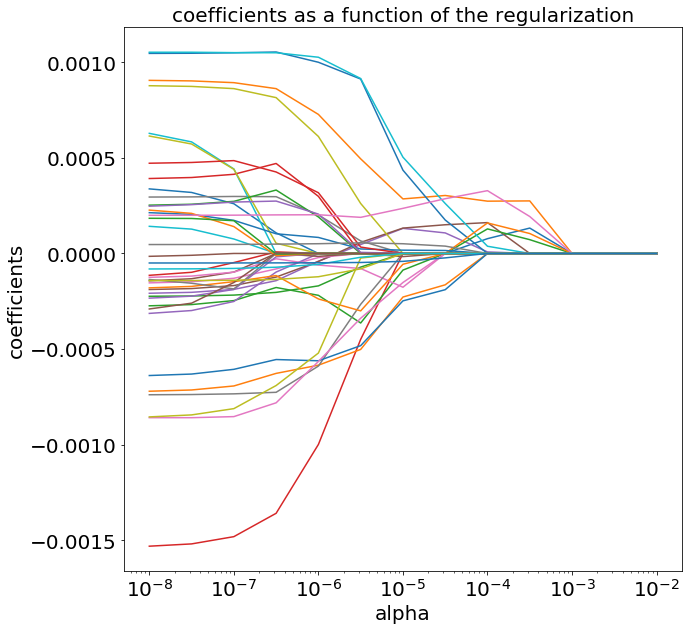



--------------------------------------------------




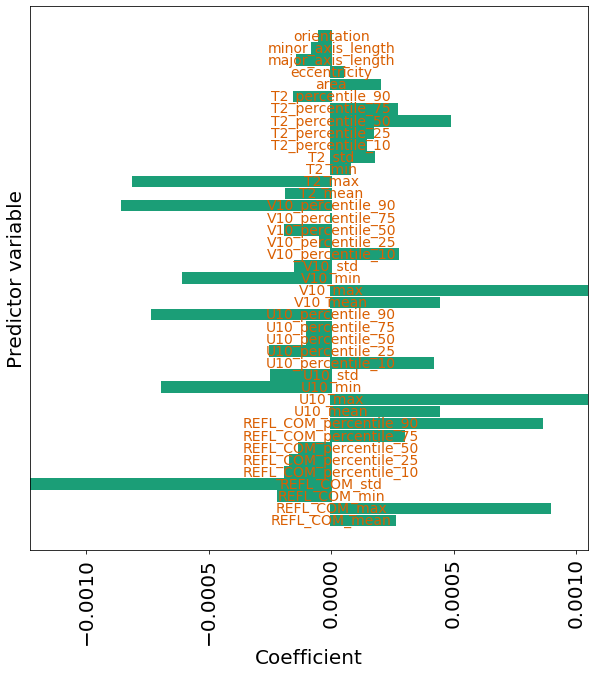



--------------------------------------------------


The results for Training samples: 
Training MAE (mean absolute error) = 7.718e-04 s^-1
Training MSE (mean squared error) = 1.113e-06 s^-2
Training bias (mean signed error) = 2.816e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


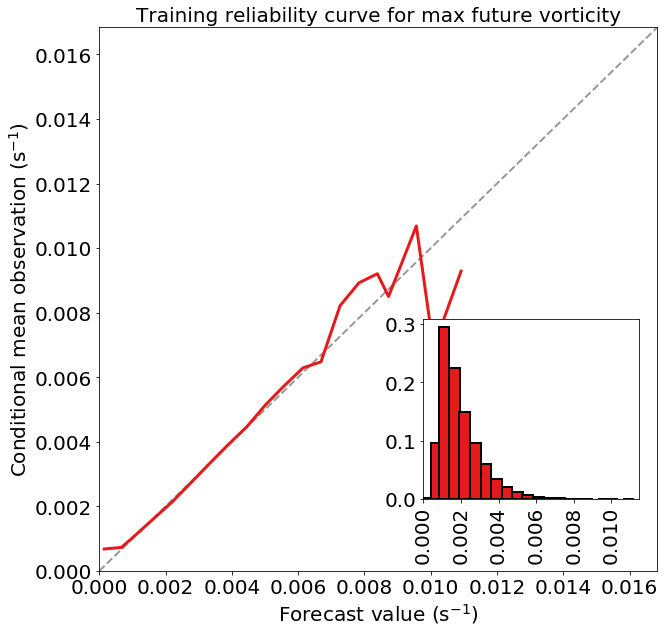



--------------------------------------------------


The results for Validation samples: 
Validation MAE (mean absolute error) = 7.509e-04 s^-1
Validation MSE (mean squared error) = 1.049e-06 s^-2
Validation bias (mean signed error) = -1.460e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.316
Validation MSE skill score (improvement over climatology) = 0.540


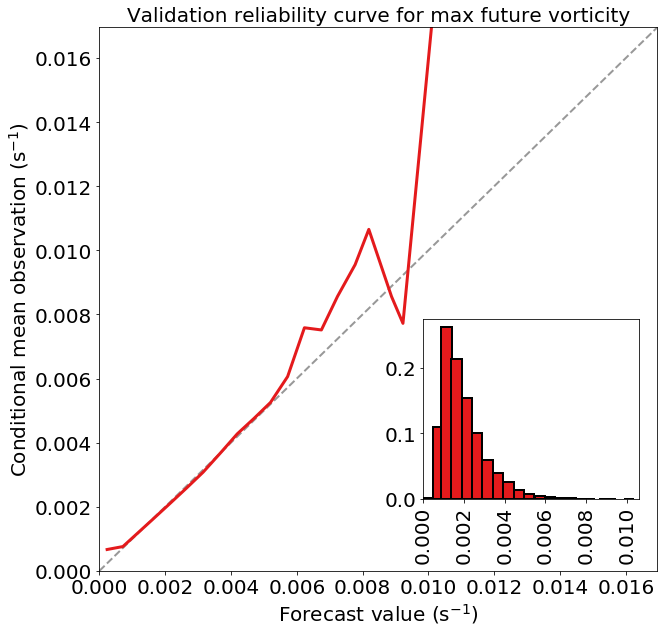



--------------------------------------------------


The results for Test samples: 
Testing MAE (mean absolute error) = 8.256e-04 s^-1
Testing MSE (mean squared error) = 1.411e-06 s^-2
Testing bias (mean signed error) = -8.952e-05 s^-1
Testing MAE skill score (improvement over climatology) = 0.339
Testing MSE skill score (improvement over climatology) = 0.556


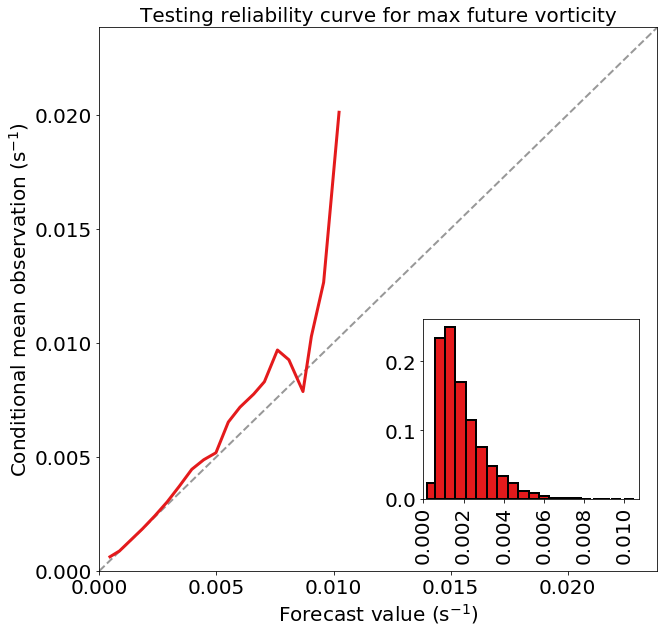

In [9]:
# calculating the mean of target values: 
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values)
mean_validation_target_value = numpy.mean(
    validation_target_table[utils.TARGET_NAME].values)
mean_test_target_value = numpy.mean(
    testing_target_table[utils.TARGET_NAME].values)


n_alphas = 13
L1 = numpy.logspace(-8, -2, n_alphas)
cv = 5

# setup the linear funciton: 
linreg_regularized_model_lasso = utils.Ridge_Lasso_linreg(
    model_type = "Lasso", alphas = L1, cv = cv)

# Training: 
reg = utils.train_linear_regression(
    model_object=linreg_regularized_model_lasso,
    training_predictor_table = training_predictor_table,
    training_target_table = training_target_table)

print("The best alpha: ", reg.alpha_)
utils.plot_find_best_alpha(training_predictor_table, training_target_table, alphas = L1, flag = 2) 
print(MINOR_SEPARATOR_STRING)

utils.plot_model_coefficients(
    model_object=linreg_regularized_model_lasso,
    predictor_names=list(training_predictor_table)
)

pyplot.show()
print(MINOR_SEPARATOR_STRING)

# predict of training samples: 
training_predictions_lasso = linreg_regularized_model_lasso.predict(
    training_predictor_table.as_matrix()
)

print("The results for Training samples: ")
# Evaluate the training samples: 
_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values = training_predictions_lasso,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

#=====================================================================================
# predict of validation samples: 
print("The results for Validation samples: ")
validation_predictions_lasso = linreg_regularized_model_lasso.predict(
    validation_predictor_table.as_matrix()
)
# Evaluation of validation  samples:
_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions_lasso,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')
print(MINOR_SEPARATOR_STRING)
#=====================================================================================
# predict of test samples:
print("The results for Test samples: ")
test_predictions_lasso = linreg_regularized_model_lasso.predict(
    testing_predictor_table.as_matrix()
)

# Evaluation of test samples: 
_ = utils.evaluate_regression(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    predicted_target_values=test_predictions_lasso,
    mean_training_target_value=mean_training_target_value,
    dataset_name='Testing')




### ElasticNet linear regression

ratio(1.000000e-01) -- n: 30 -- alpha: 0.000009 -- mse: 0.000001 -- 
ratio(1.988889e-01) -- n: 30 -- alpha: 0.000005 -- mse: 0.000001 -- 
ratio(2.977778e-01) -- n: 30 -- alpha: 0.000003 -- mse: 0.000001 -- 
ratio(3.966667e-01) -- n: 30 -- alpha: 0.000002 -- mse: 0.000001 -- 
ratio(4.955556e-01) -- n: 30 -- alpha: 0.000002 -- mse: 0.000001 -- 
ratio(5.944444e-01) -- n: 30 -- alpha: 0.000002 -- mse: 0.000001 -- 
ratio(6.933333e-01) -- n: 30 -- alpha: 0.000001 -- mse: 0.000001 -- 
ratio(7.922222e-01) -- n: 30 -- alpha: 0.000001 -- mse: 0.000001 -- 
ratio(8.911111e-01) -- n: 30 -- alpha: 0.000001 -- mse: 0.000001 -- 
ratio(9.900000e-01) -- n: 30 -- alpha: 0.000001 -- mse: 0.000001 -- 
Best l1_ratio and alpha: 0.990000, 0.000001


--------------------------------------------------




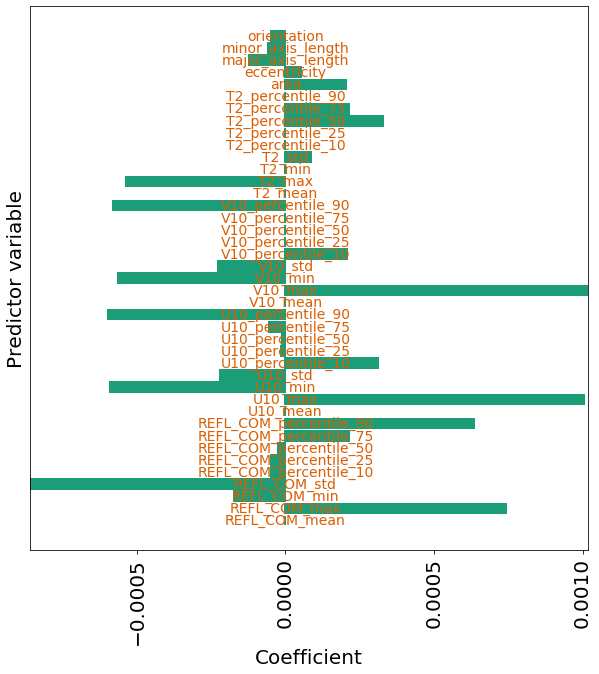



--------------------------------------------------


The results for Training samples: 
Training MAE (mean absolute error) = 7.725e-04 s^-1
Training MSE (mean squared error) = 1.115e-06 s^-2
Training bias (mean signed error) = 1.911e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.314
Training MSE skill score (improvement over climatology) = 0.520


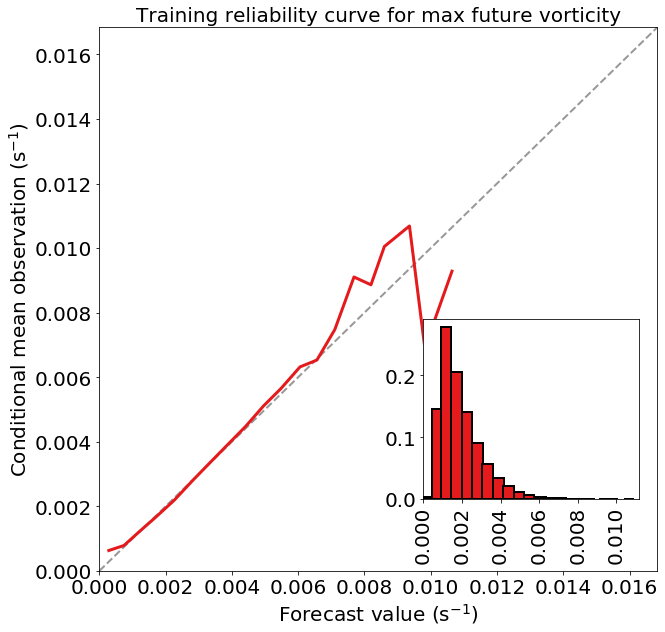



--------------------------------------------------


The results for Validation samples: 
Validation MAE (mean absolute error) = 7.513e-04 s^-1
Validation MSE (mean squared error) = 1.051e-06 s^-2
Validation bias (mean signed error) = -5.430e-07 s^-1
Validation MAE skill score (improvement over climatology) = 0.315
Validation MSE skill score (improvement over climatology) = 0.539


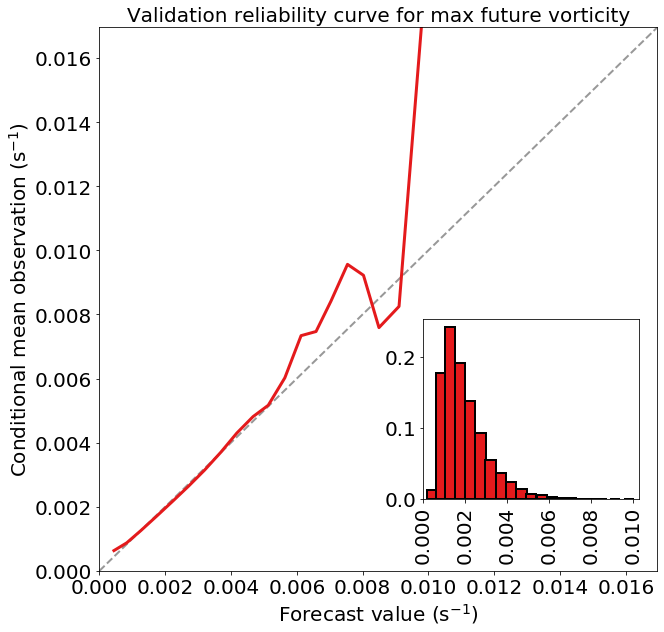



--------------------------------------------------


The results for Test samples: 
Testing MAE (mean absolute error) = 8.266e-04 s^-1
Testing MSE (mean squared error) = 1.418e-06 s^-2
Testing bias (mean signed error) = -9.080e-05 s^-1
Testing MAE skill score (improvement over climatology) = 0.338
Testing MSE skill score (improvement over climatology) = 0.553


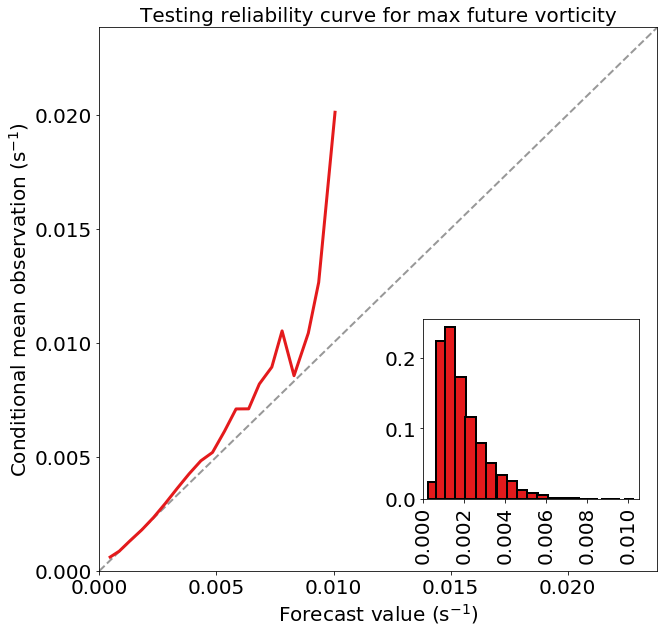

In [10]:
# calculating the mean of target values: 
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values)
mean_validation_target_value = numpy.mean(
    validation_target_table[utils.TARGET_NAME].values)
mean_test_target_value = numpy.mean(
    testing_target_table[utils.TARGET_NAME].values)


n_alphas = 13
alphas = numpy.logspace(-8, 6, n_alphas) 
l1_ratios = 0.5 
cv = 5

# setup the linear funciton: 

best_l1_ratio, best_alpha = utils.EN_model_setup(training_predictor_table.as_matrix(), training_target_table) 
linreg_regularized_model_ENet = utils.EL_linreg(l1_ratio = best_l1_ratio, alpha = best_alpha) 
print(MINOR_SEPARATOR_STRING)
# Training: 
reg = utils.train_linear_regression(
    model_object=linreg_regularized_model_ENet,
    training_predictor_table = training_predictor_table,
    training_target_table = training_target_table)

#=====================================================================================

utils.plot_model_coefficients(
    model_object=linreg_regularized_model_ENet, 
    predictor_names=list(training_predictor_table)
)

pyplot.show()
print(MINOR_SEPARATOR_STRING)
#=====================================================================================
# predict of training samples: 
training_predictions_ENet = linreg_regularized_model_ENet.predict(
    training_predictor_table.as_matrix()
)
#=====================================================================================
print("The results for Training samples: ")
# Evaluate the training samples: 
_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions_ENet,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

#=====================================================================================
# predict of validation samples: 
print("The results for Validation samples: ")
validation_predictions_ENet = linreg_regularized_model_ENet.predict(
    validation_predictor_table.as_matrix()
)
# Evaluation of validation  samples:
_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions_ENet,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')
print(MINOR_SEPARATOR_STRING)
#=====================================================================================
# predict of test samples:
print("The results for Test samples: ")
test_predictions_ENet = linreg_regularized_model_ENet.predict(
    testing_predictor_table.as_matrix()
)

# Evaluation of test samples: 
_ = utils.evaluate_regression(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    predicted_target_values=test_predictions_ENet,
    mean_training_target_value=mean_training_target_value,
    dataset_name='Testing')



r^2 on test data for ordinary model: 0.554508
r^2 on test data for ridge model: 0.554470
r^2 on test data for ridge model: 0.554409
r^2 on test data : 0.552023


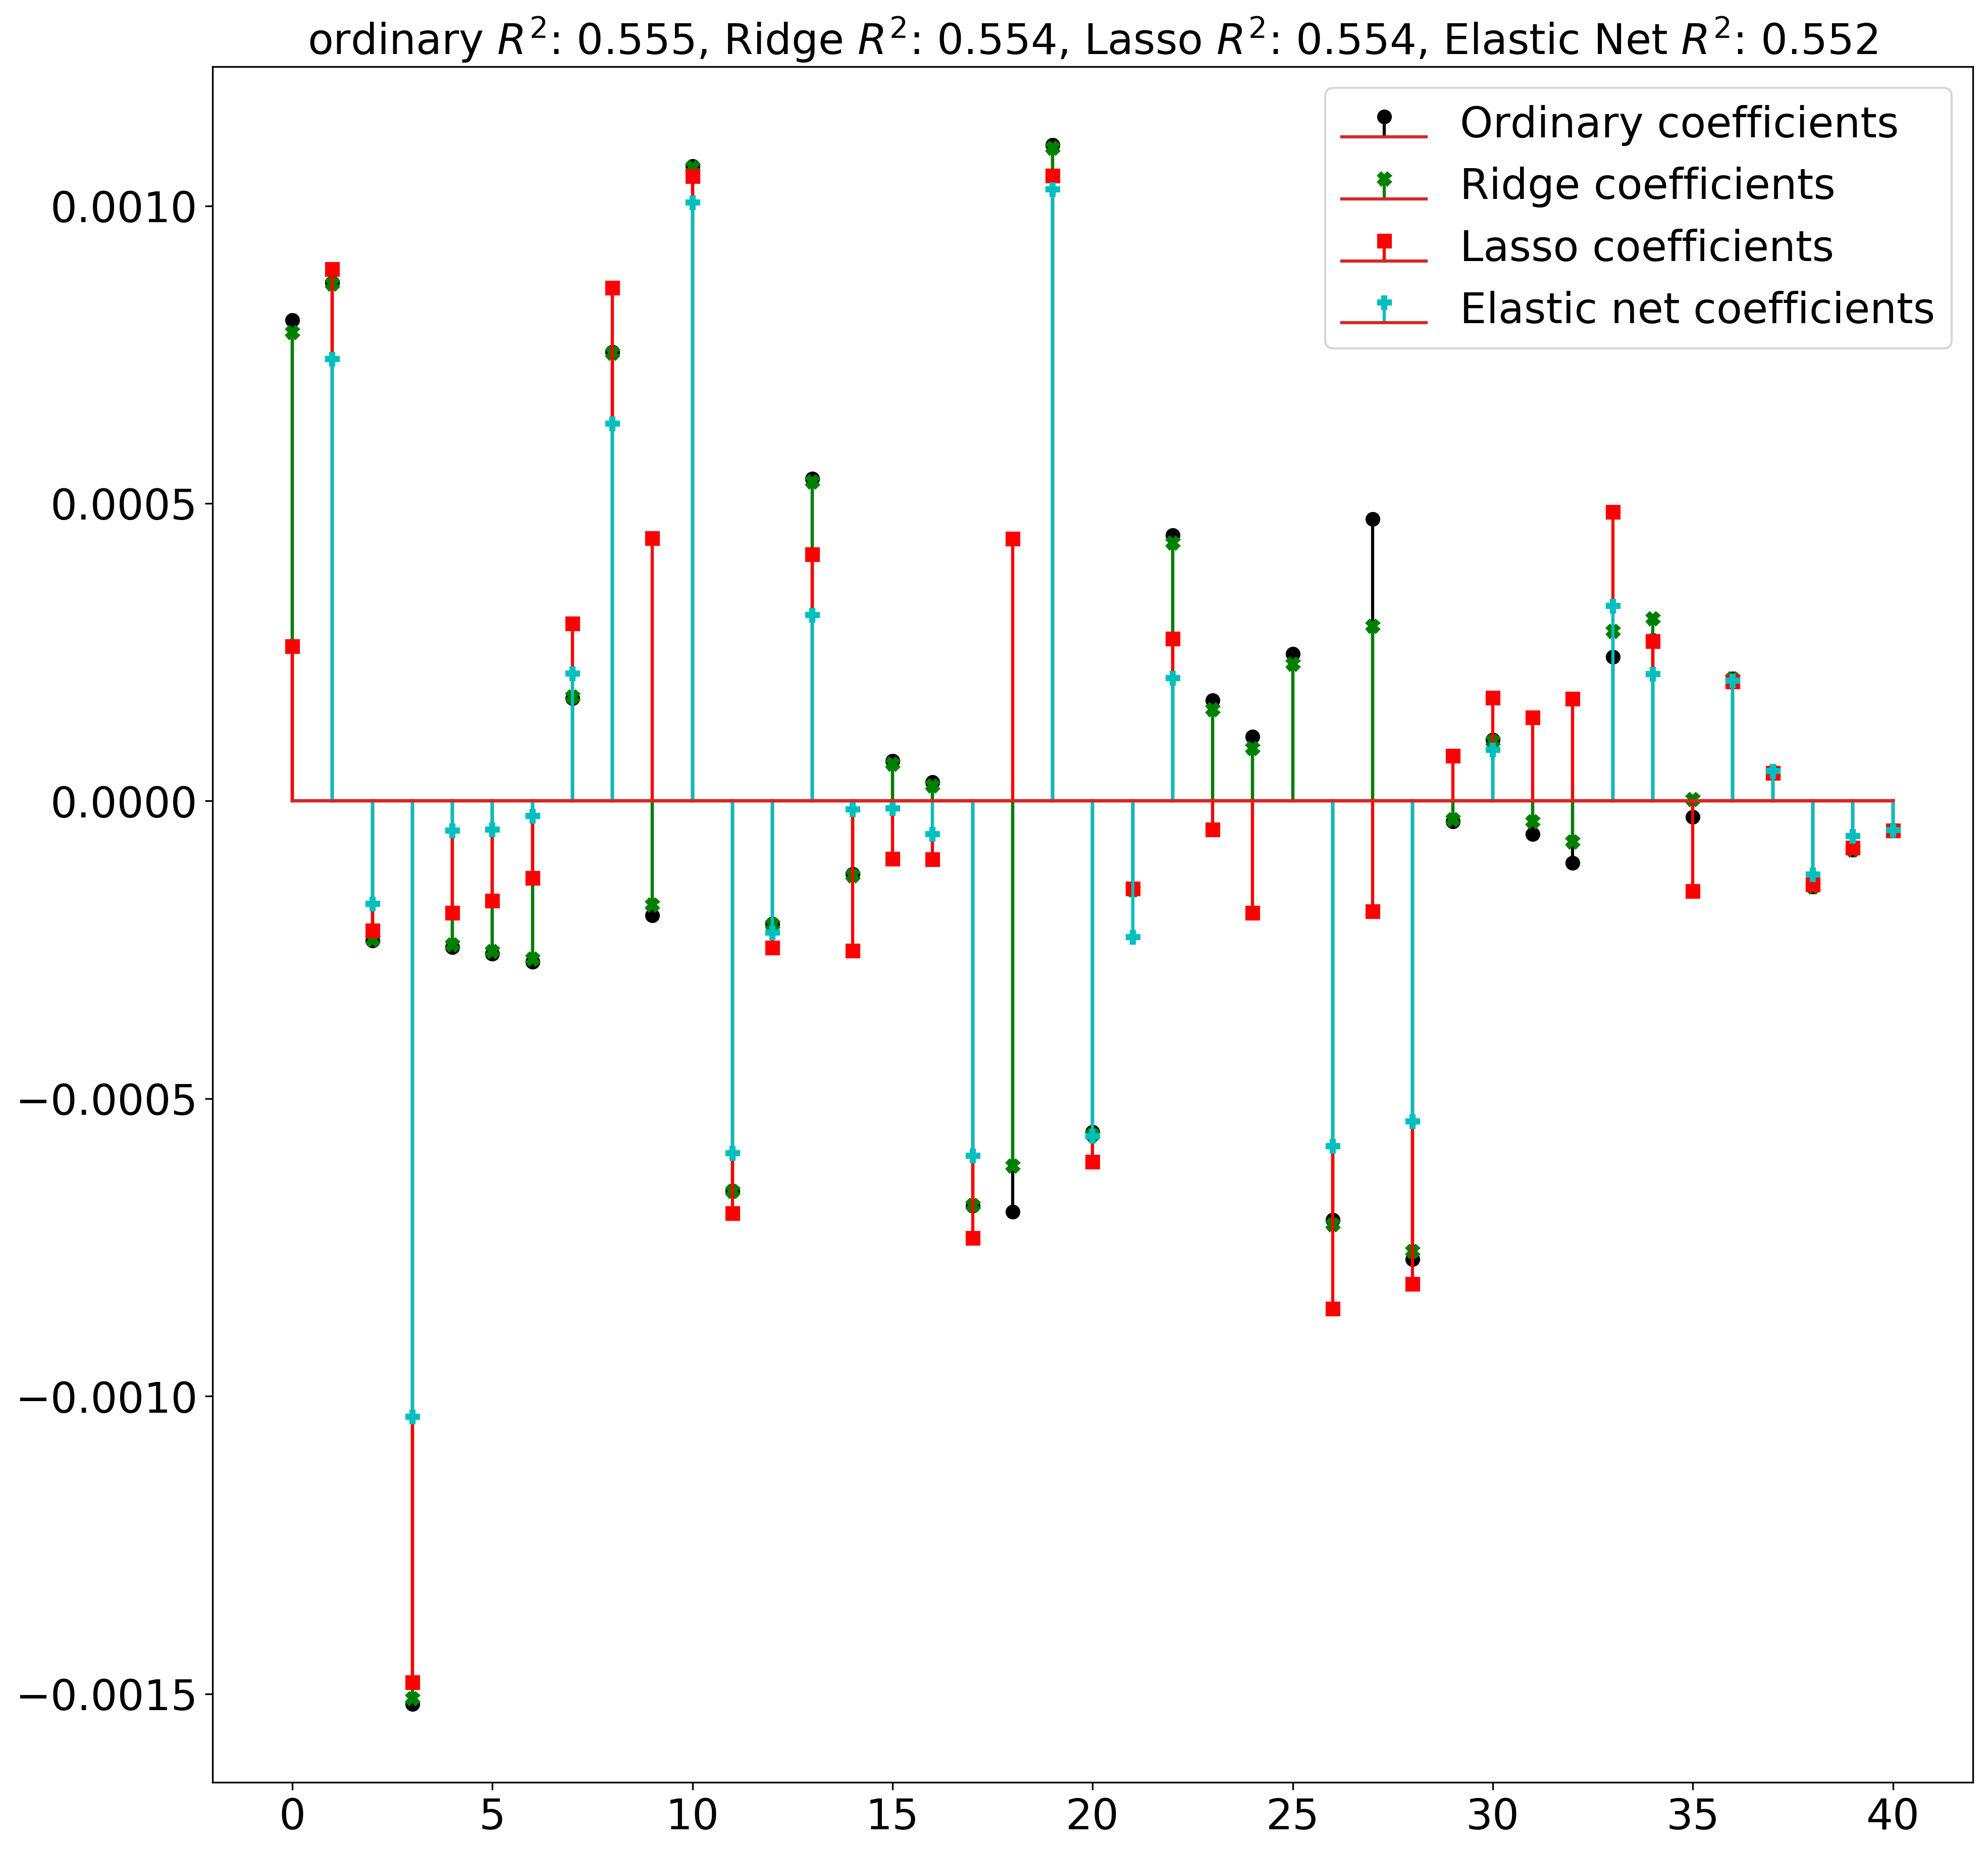

In [11]:
import numpy 
import matplotlib.pyplot as pyplt
from sklearn.metrics import r2_score
import sklearn 


r2_score_ordinary = sklearn.metrics.r2_score(testing_target_table[utils.TARGET_NAME].values, test_prediction_ordinary)
print("r^2 on test data for ordinary model: %f" % r2_score_ordinary) 

r2_score_ridge = sklearn.metrics.r2_score(testing_target_table[utils.TARGET_NAME].values, test_predictions_ridge)
print("r^2 on test data for ridge model: %f" % r2_score_ridge)  

r2_score_lasso = sklearn.metrics.r2_score(testing_target_table[utils.TARGET_NAME].values, test_predictions_lasso)
print("r^2 on test data for ridge model: %f" % r2_score_lasso) 

r2_score_enet = sklearn.metrics.r2_score(testing_target_table[utils.TARGET_NAME].values, test_predictions_ENet)
print("r^2 on test data : %f" % r2_score_enet)

#
pyplt.figure(
    figsize=(15, 15),
    dpi=300)

m, s, _ = pyplt.stem(numpy.where(linreg_model_ordinary.coef_)[0], linreg_model_ordinary.coef_[linreg_model_ordinary.coef_ != 0],
                   markerfmt='o', label='Ordinary coefficients')
pyplt.setp([m, s], color='k')
m, s, _ = pyplt.stem(numpy.where(linreg_regularized_model_ridge.coef_)[0], linreg_regularized_model_ridge.coef_[linreg_regularized_model_ridge.coef_ != 0],
                   markerfmt='X', label='Ridge coefficients')
pyplt.setp([m, s], color='g')

m, s, _ = pyplt.stem(numpy.where(linreg_regularized_model_lasso.coef_)[0], linreg_regularized_model_lasso.coef_[linreg_regularized_model_lasso.coef_ != 0],
                   markerfmt='s', label='Lasso coefficients')
pyplt.setp([m, s], color='r')

m, s, _ = pyplt.stem(numpy.where(linreg_regularized_model_ENet.coef_)[0], linreg_regularized_model_ENet.coef_[linreg_regularized_model_ENet.coef_ != 0],
                   markerfmt='P', label='Elastic net coefficients')
pyplt.setp([m, s], color="c")

    
pyplt.legend(loc='best')
pyplt.title("ordinary $R^2$: %.3f, Ridge $R^2$: %.3f, Lasso $R^2$: %.3f, Elastic Net $R^2$: %.3f"
          % (r2_score_ordinary, r2_score_ridge, r2_score_lasso, r2_score_enet))
pyplt.show()

# Binary Classification

 - **The rest of this module focuses on binary classification, rather than regression.**
 - "Regression" is the prediction of a real number (*e.g.*, above, where we predicted max future vorticity).
 - "Classification" is the prediction of a category (*e.g.*, low, medium, or high max future vorticity).
<br><br>
 - **In binary classification there are two categories.**
 - Thus, prediction takes the form of answering a **yes-or-no question.**
 - We will use the same target variable (max future vorticity), except we will binarize it.
 - The problem will be predicting whether or not max future vorticity exceeds a threshold.

# Binarization

 - The next cell "binarizes" the target variable (turns each value into a 0 or 1, yes or no).
 - The threshold is the 90$^{\textrm{th}}$ percentile of max future vorticity over all training examples.
 - The same threshold is used to binarize training, validation, and testing data.

In [12]:
binarization_threshold = utils.get_binarization_threshold(
    csv_file_names=training_file_names, percentile_level=90.)
print(MINOR_SEPARATOR_STRING)

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    'Real-numbered target values for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

training_target_values = utils.binarize_target_values(
    target_values=training_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

training_target_table = training_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: training_target_values}
)

print('\nBinarization threshold = {0:.3e} s^-1'.format(
    binarization_threshold
))

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    '\nBinarized target values for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

validation_target_values = utils.binarize_target_values(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

validation_target_table = validation_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: validation_target_values}
)

testing_target_values = utils.binarize_target_values(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

testing_target_table = testing_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: testing_target_values}
)

Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "./data/track_data_ncar_ams_3km_csv_small\track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: "./data/t

# Logistic Regression

**Logistic regression is basically linear regression for binary classification.**
<br><br>
Recall the equation for linear regression:
<br>
$\hat{y} = \beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j$
<br><br>
Only the left-hand side is changed for logistic regression:
<br>
$\textrm{ln}(\frac{\hat{y}}{1 - \hat{y}}) = \beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j$
<br><br>
This can be rewritten as:
<br>
$\hat{y} = \frac{\textrm{exp}(\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j)}{1 + \textrm{exp}(\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j)}$
<br><br>
**This forces $\hat{y}$ to have limits of $\left[0, 1\right]$, so it can be interpreted as a probability.**  The weights ($\beta_0$ and $\beta_j$) are trained to minimize cross-entropy, rather than mean squared error.
<br><br>
$\epsilon = -\frac{1}{N} \sum\limits_{i = 1}^{N} \left[ y_i\textrm{ log}_2(\hat{y}_i) + (1 - y_i)\textrm{ log}_2(1 - \hat{y}_i) \right]$
<br>
 - $\hat{y}_i$ = forecast probability for $i^{\textrm{th}}$ example.  This is probability that the event occurs (so class = 1 or "yes").  In our case, this is probability that max future vorticity $\ge 3.850 \times 10^{-3}\textrm{ s}^{-1}$.
 - $y_i$ = true label for $i^{\textrm{th}}$ example (0 or 1)
 - $N$ = number of training examples
 - $\epsilon$ = cross-entropy
<br><br>
 - **Cross-entropy varies from $\left[0, \infty\right)$ and is negatively oriented (lower is better).**
 - Cross-entropy comes from information theory and is proportional to the number of bits needed to describe the difference between the two distributions (predictions and labels).
 - When the distributions are equivalent ($\hat{y}_i = 1.0$ for all positive examples and $\hat{y}_i = 0.0$ for all negative examples), the number of bits is zero, so cross-entropy is zero.

<br>
As for linear regression, the derivatives of model coefficients with respect to cross-entropy are as follows.
<br>
$\frac{\partial \epsilon}{\partial \beta_0} = \frac{2}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$
<br>
$\frac{\partial \epsilon}{\partial \beta_j} = \frac{2}{N} \sum\limits_{i = 1}^{N} x_{ij} (\hat{y}_i - y_i)$
<br><br>
**As for linear regression, the weights ($\beta_0$ and $\beta_j$) are adjusted during training via gradient descent.**

$\beta_0 \leftarrow \beta_0 - \alpha \frac{\partial \epsilon}{\partial \beta_0}$
<br>
$\beta_j \leftarrow \beta_j - \alpha \frac{\partial \epsilon}{\partial \beta_j}$

# Logistic Regression: Example

**The next cell does the following:**

 - Trains a logistic-regression model (with default hyperparameters) to predict the label for each storm (whether or not max future vorticity $\ge 3.850 \times 10^{-3}\textrm{ s}^{-1}$).
 - Evaluates the model on both training and validation data.

**For both training and validation data, this cell plots the following graphics:**

 - ROC (receiver operating characteristic) curve (Metz 1978)
 - Performance diagram (Roebber 2009)
 - Attributes diagram (Hsu and Murphy 1986)

These graphics are described below the cell.

Training Max Peirce score (POD - POFD) = 0.639
Training AUC (area under ROC curve) = 0.896
Training Max CSI (critical success index) = 0.375
Training Brier score = 0.064
Training Brier skill score (improvement over climatology) = 0.293


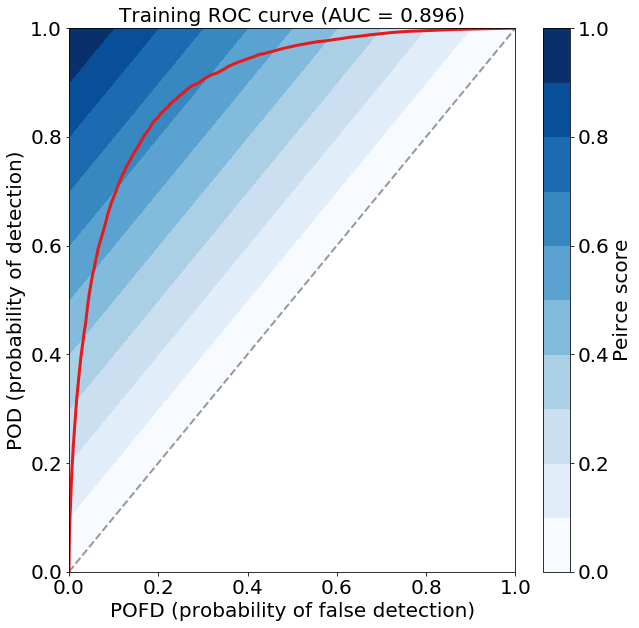

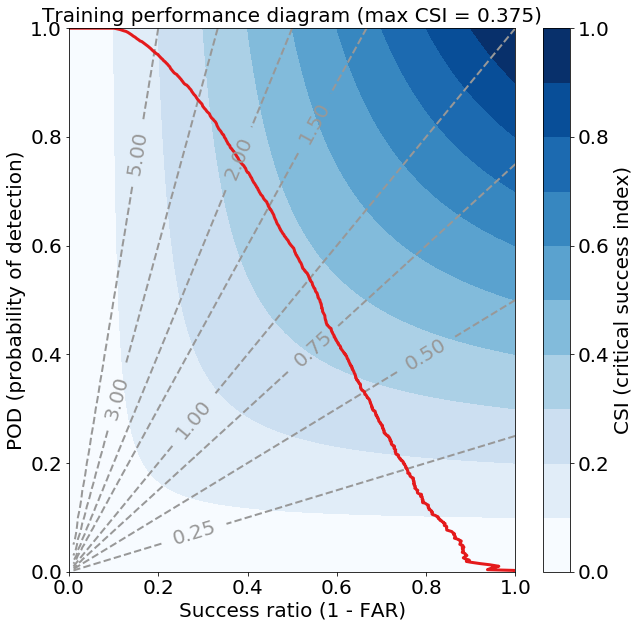

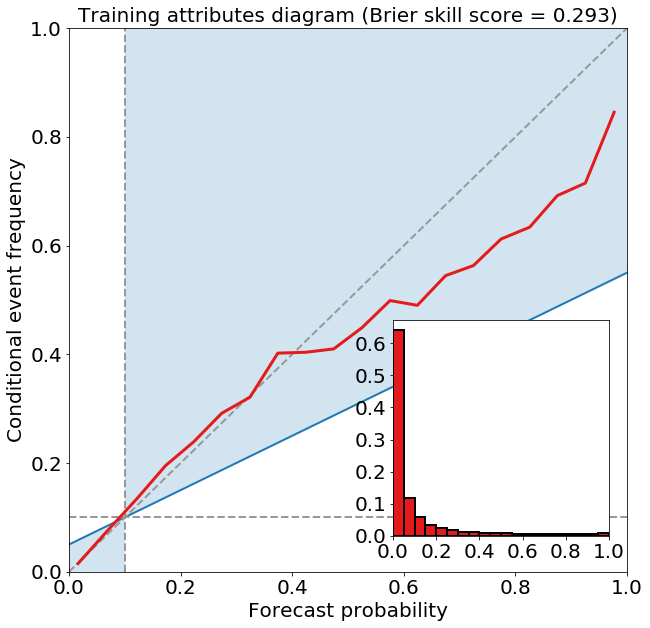

Validation Max Peirce score (POD - POFD) = 0.649
Validation AUC (area under ROC curve) = 0.902
Validation Max CSI (critical success index) = 0.382
Validation Brier score = 0.063
Validation Brier skill score (improvement over climatology) = 0.307


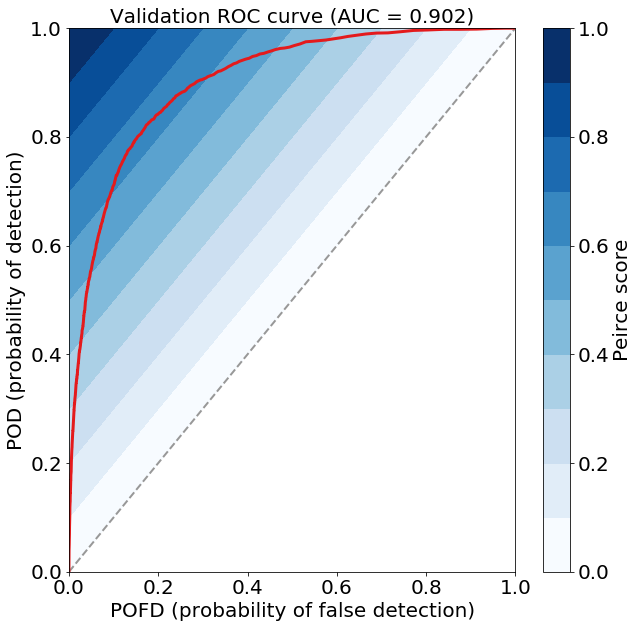

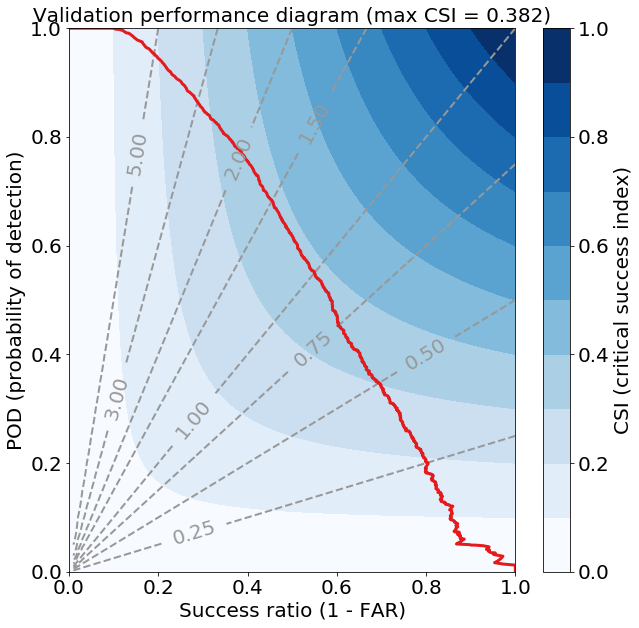

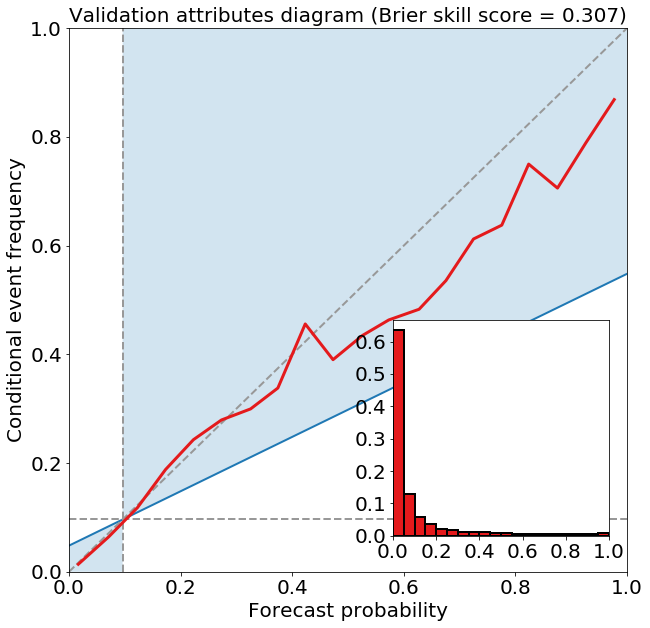

In [13]:
plain_log_model_object = utils.setup_logistic_regression(
    lambda1=0., lambda2=0.)

_ = utils.train_logistic_regression(
    model_object=plain_log_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = plain_log_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

_ = utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = plain_log_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

_ = utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Contingency Table

**Most evaluation methods for binary classification are based on the contingency table** (or "confusion matrix"), shown below.

<img src="contingency_table.png" alt="Contingency table" width="500" />

 - $a$ = number of true positives (forecast = label = "yes")
 - $b$ = number of false positives (forecast = "yes" but label = "no")
 - $c$ = number of false negatives (forecast = "no" but label = "yes")
 - $d$ = number of true negatives (forecast = label = "no")
<br><br>
 - **Problem**: most classification models (including logistic regression) output probabilities, rather than yeses and nos.
 - **Solution**: determinize the probabilities.
 - "Determinize" is just a fancy way of saying "turn the probabilities into yeses and nos".
 - This is done with the following equation, where $p$ = probability; $p^*$ = threshold; and $\hat{y}$ is the resulting deterministic forecast.

$\hat{y} = \begin{cases}1,\quad\textrm{if }p \ge p^* \\0,\quad\textrm{otherwise}\end{cases}$

 - The best threshold is usually **not** 0.5.
 - Keep in mind that $p^*$ is a hyperparameter, so it should be optimized on the validation data.

**The following scores can be computed from the contingency table.**

<img src="ct_scores.png" alt="Scores from contingency table" width="500" />

# ROC Curve

 - The ROC curve plots POD (probability of detection) vs. POFD (probability of false detection) with varying threshold $p^*$.
 - Each point in the curve corresponds to one $p^*$ value.
 - For $p^*$ = 0, POD = POFD = 1.
 - For $p^*$ = 1, POD = POFD = 0.

**Two numbers can be used to summarize the goodness of the ROC curve:**

 - Maximum Peirce score (POD - POFD) over all thresholds
 - Area under the curve (AUC)
 - Generally, an AUC $\ge$ 0.9 is considered "excellent".
 - AUC = 0.5 (dashed grey line) for a random model.

# Performance Diagram

 - The performance diagram plots POD (probability of detection) vs. success ratio (1 - FAR).
 - Again, each point corresponds to one $p^*$ value.
 - For $p^*$ = 0, POD = 1 and success ratio is minimized.
 - For $p^*$ = 1, POD = 0 and success ratio is maximized.

CSI (critical success index) and frequency bias are contoured in the background.  They can be expressed in POD&ndash;success-ratio space as follows.
<br><br>
$\textrm{bias} = \frac{\textrm{POD}}{\textrm{SR}}$
<br>
$\textrm{CSI}^{-1} = \textrm{POD}^{-1} + \textrm{SR}^{-1} - 1$
<br><br>

**A few numbers can be used to summarize the goodness of the performance diagram:**

 - Maximum CSI
 - Frequency bias at maximum CSI (should occur with a frequency bias near 1.0)
 - Area under curve
<br><br>
 - However, unlike the ROC curve, these numbers are very sensitive to the class distribution.
 - Thus, thresholds for "good" and "bad" depend on the class distribution.
 - For some rare events a max CSI of 0.10 may be excellent; for common events a max CSI of 0.8 may be poor.

# Attributes Diagram

 - The attributes diagram is a reliability curve for binary classification, plus a few reference lines in the background.
 - **Plots forecast probability vs. conditional mean frequency.**
 - This answers the question: **"given forecast probability $p$, how likely is the event?"**
<br><br>
 - **For perfect reliability, conditional event frequency = forecast probability always.**
 - This is represented by the diagonal grey line ($x = y$), called the "perfect-reliability line".
 - The vertical grey line is the "climatology line," representing the event frequency in the training data, which is just called "climatology".  Climatology in our case is 10%.  If the model always forecast climatology, the reliability curve would collapse to a single point on this line.
 - The horizontal grey line is the "no-resolution line," also based on training-set climatology.  If the model were completely random, the reliability curve would approx follow this line.
<br><br>
 - **The blue shading is the "positive-skill area," where Brier skill score $>$ 0.**
 - Brier skill score (BSS) is the Brier score (BS) relative to climatology.
<br><br>
$\textrm{BS} = \frac{1}{N} \sum\limits_{i = 1}^{N} (p_i - y_i)^2$
<br>
$\textrm{BSS} = \frac{\textrm{BS}_{\textrm{climo}} - \textrm{BS}}{\textrm{BS}_{\textrm{climo}}}$

# Logistic Regression: Coefficients

 - The next cell plots coefficients for the logistic-regression model.
 - Positive (negative) coefficients mean that probability increases (decreases) with the predictor variable.
 - Again, predictors have been normalized to the same scale ($z$-scores), so generally predictors with larger coefficients are more important.

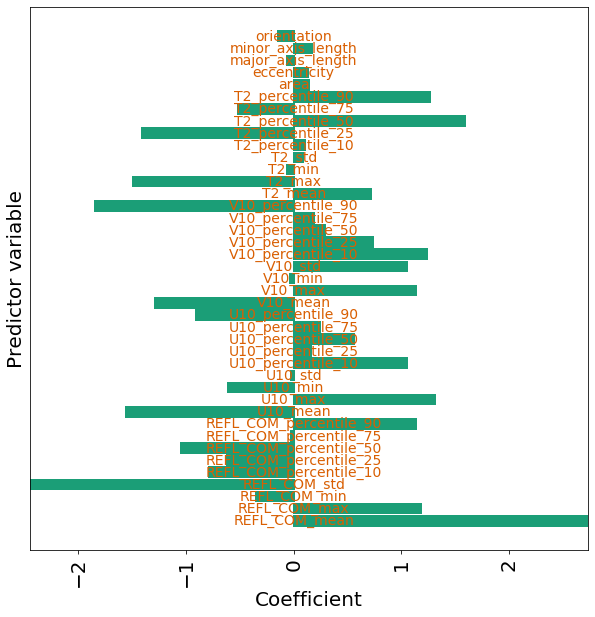

In [14]:
utils.plot_model_coefficients(
    model_object=plain_log_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Logistic Regression with $L_1$ and $L_2$

 - The next cell trains a logistic-regression model with both $L_1$ and $L_2$ regularization.
 - As for linear regression, you could do a hyperparameter experiment to find the best $\lambda_1$ and $\lambda_2$ for logistic regression.
 - Now you can see why just saying "lasso regression" or "ridge regression" or "elastic-net regression" is not descriptive enough.  This type of regularization can be applied to different base models.

Validation Max Peirce score (POD - POFD) = 0.662
Validation AUC (area under ROC curve) = 0.907
Validation Max CSI (critical success index) = 0.395
Validation Brier score = 0.062
Validation Brier skill score (improvement over climatology) = 0.318


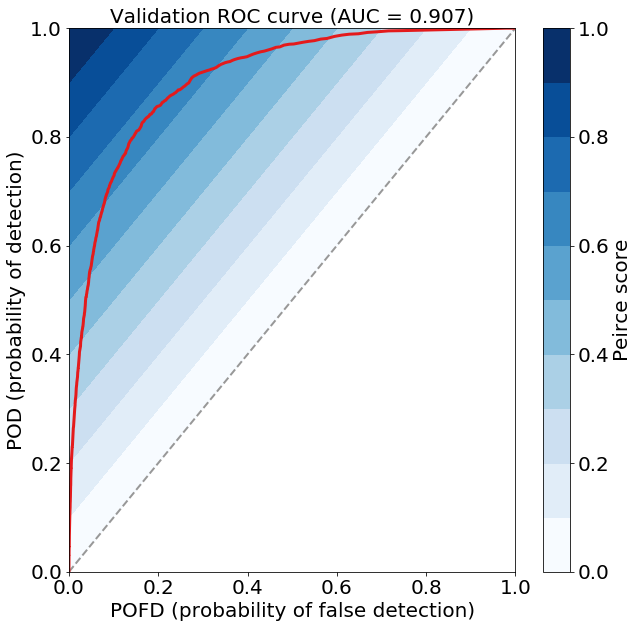

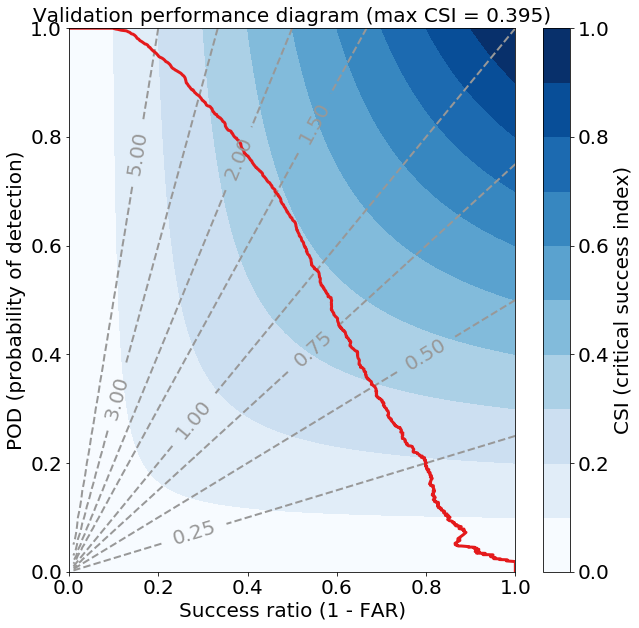

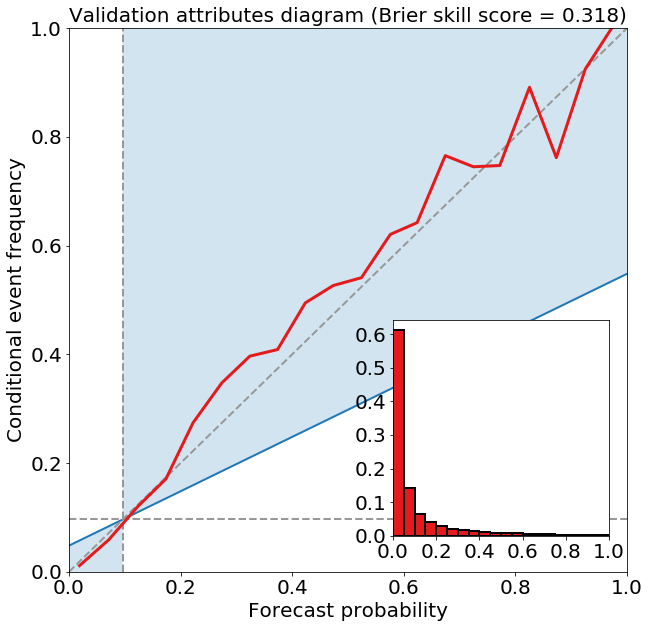

{'max_peirce_score': 0.6619912879841929,
 'area_under_roc_curve': 0.9069790125489064,
 'max_csi': 0.395419078781777,
 'brier_score': 0.06154797422360745,
 'brier_skill_score': 0.318219542411668}

In [15]:
logistic_en_model_object = utils.setup_logistic_regression(
    lambda1=1e-3, lambda2=1e-3)

_ = utils.train_logistic_regression(
    model_object=logistic_en_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

validation_probabilities = logistic_en_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Logistic Regression with $L_1$ and $L_2$: Coefficients

The next cell plots coefficients for the logistic-regression model with both penalties.
<br><br>
Many coefficients are zero, and the non-zero ones are about an order of magnitude smaller than for the original model.

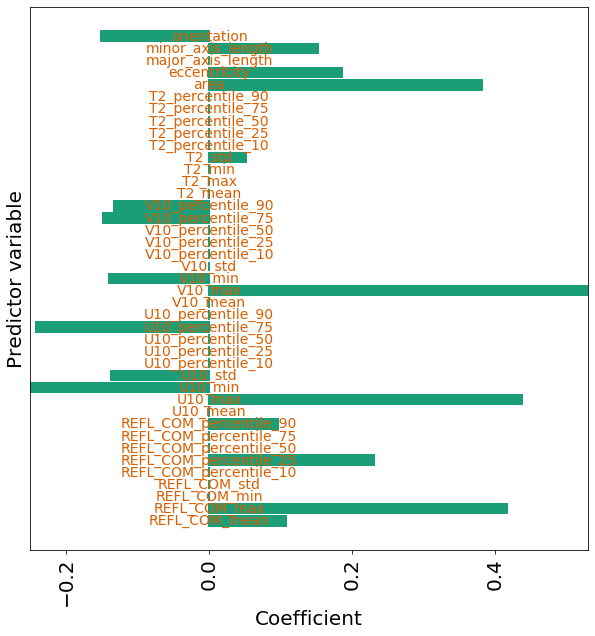

In [16]:
utils.plot_model_coefficients(
    model_object=logistic_en_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Decision Trees

 - A decision tree is a flow chart with **branch nodes** (ellipses) and **leaf nodes** (rectangles).  In the figure below, $f$ is the forecast probability of severe weather.

<img src="tree_schematic.jpg" alt="Decision-tree schematic" width="500" />
 
 - The branch nodes are bifurcating, and the leaf nodes are terminal.
 - In other words, each branch node has 2 children and each leaf node has 0 children.
 - **Predictions are made at the leaf nodes, and questions are asked at the branch nodes.**
 - Since the branch nodes are bifurcating, **questions asked at the branch nodes must be yes-or-no.**
<br><br>
 - Decision trees have been used in meteorology since the 1960s (Chisholm 1968).
 - They were built subjectively by human experts until the 1980s, when an objective algorithm (Quinlan 1986) was developed to "train" them (determine the best question at each branch node).
<br><br>
 - **The prediction at leaf node $L$ is the average of all training examples that reached $L$.**
 - For regression this is a real value (average max future vorticity of examples that reached $L$).
 - For classification this is a probability (fraction of examples that reached $L$ with max future vorticity $\ge 3.850 \times 10^{-3}\textrm{ s}^{-1}$).
<br><br>
 - **The question chosen at each branch node is that which maximizes information gain.**
 - **This is done by minimizing the "remainder,"** which is based on entropy of the child nodes.
 - The entropy of one node is defined below.
<br><br>
$E = -\frac{1}{n} \left[ f\textrm{ log}_2(f) + f\textrm{ log}_2(f) \right]$
<br><br>
 - $n$ = number of examples at the node
 - $f$ = fraction of these examples that are in the positive class

<br>
**The "remainder" is defined as follows.**
<br><br>
$R = \frac{n_{\textrm{left}} E_{\textrm{left}} + n_{\textrm{right}} E_{\textrm{right}}}{n_{\textrm{left}} + n_{\textrm{right}}}$
<br><br>
 - $n_{\textrm{left}}$ = number of examples sent to left child (for which the answer to the question is "no")
<br>
 - $n_{\textrm{left}}$ = number of examples sent to right child (for which answer is "yes")
<br>
 - $E_{\textrm{left}}$ = entropy of left child
<br>
 - $E_{\textrm{right}}$ = entropy of right child

# Decision Tree: Example

The next cell trains a decision tree, with default hyperparameters, to forecast the probability that a storm will develop future vorticity $\ge 3.850 \times 10^{-3}\textrm{ s}^{-1}$.

Training Max Peirce score (POD - POFD) = 0.781
Training AUC (area under ROC curve) = 0.955
Training Max CSI (critical success index) = 0.471
Training Brier score = 0.049
Training Brier skill score (improvement over climatology) = 0.459


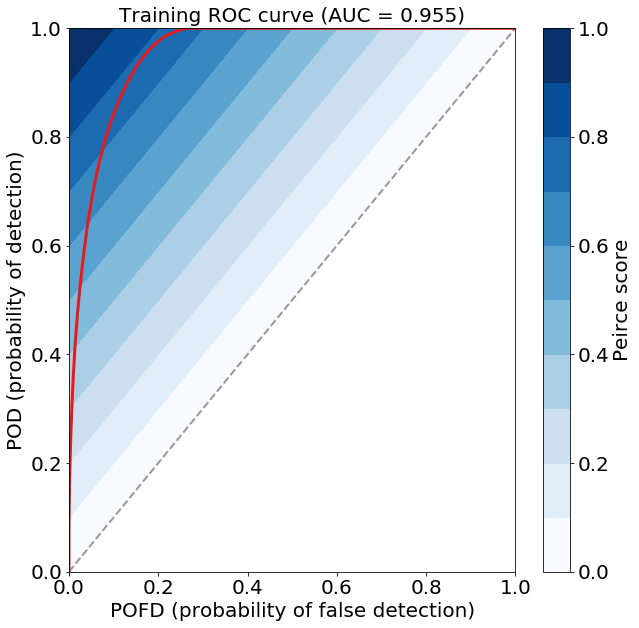

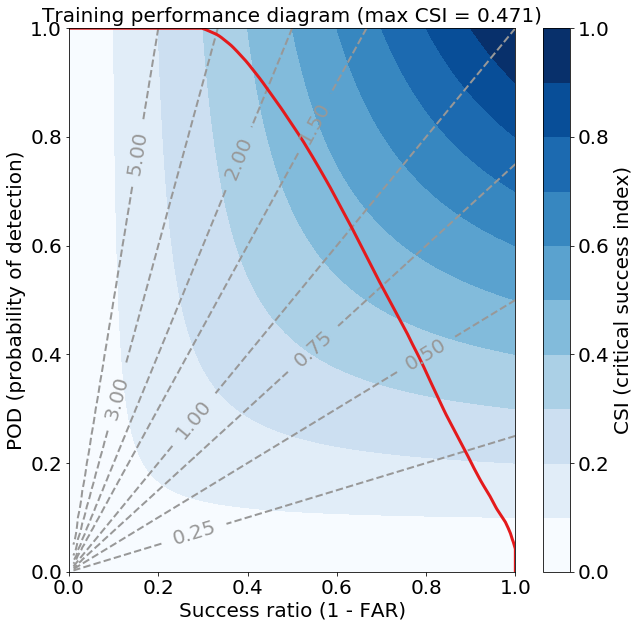

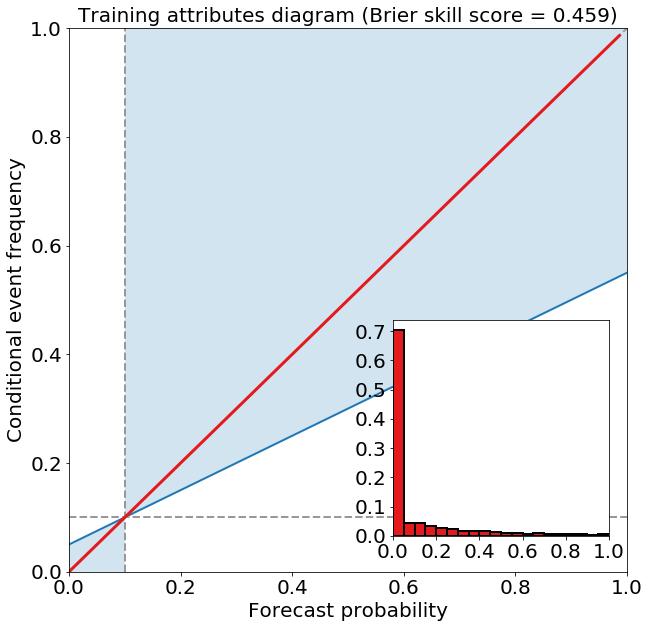

Validation Max Peirce score (POD - POFD) = 0.598
Validation AUC (area under ROC curve) = 0.854
Validation Max CSI (critical success index) = 0.342
Validation Brier score = 0.069
Validation Brier skill score (improvement over climatology) = 0.233


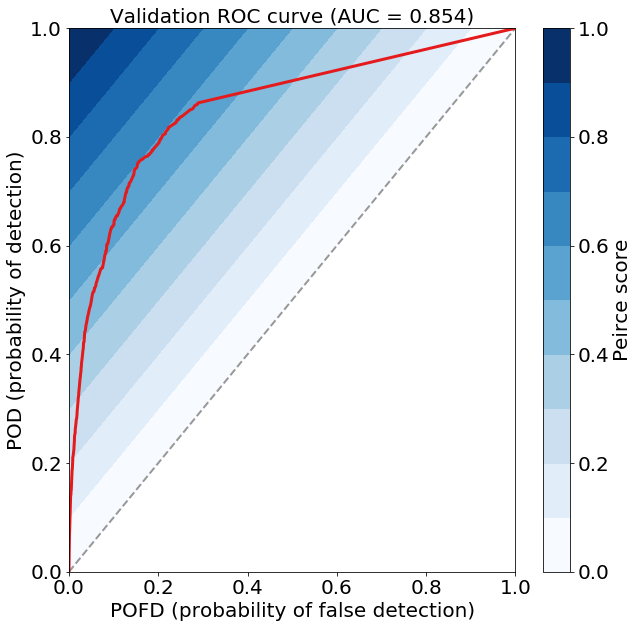

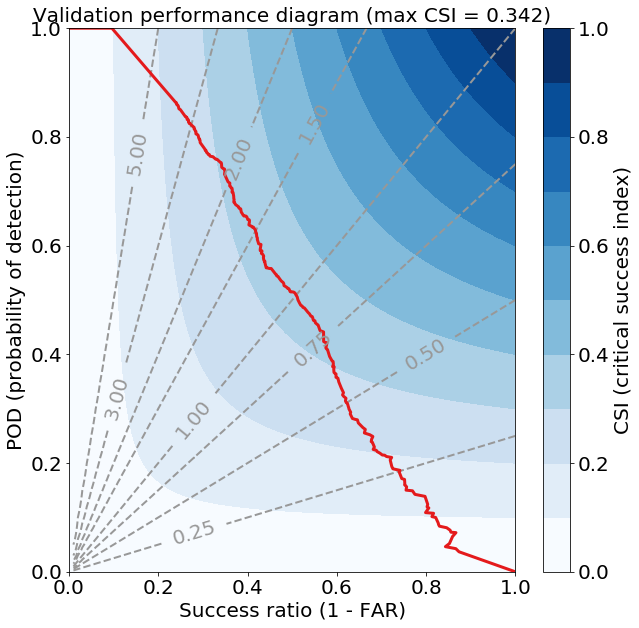

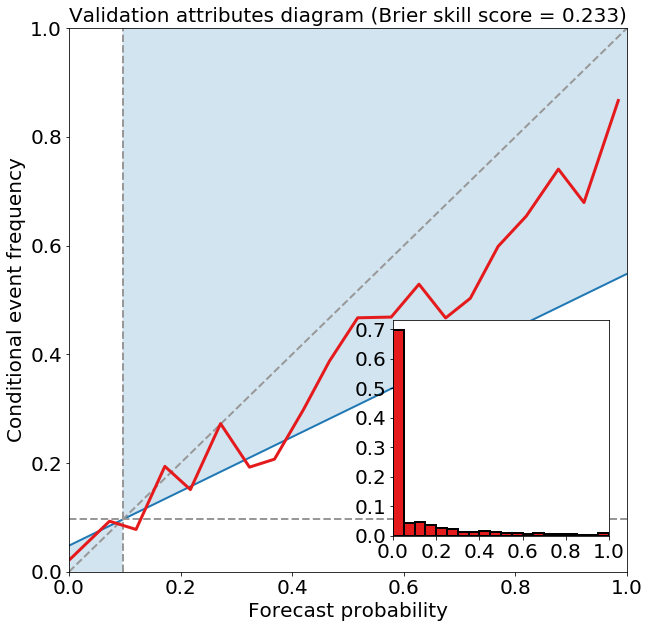

{'max_peirce_score': 0.5977671359299315,
 'area_under_roc_curve': 0.8539744298017814,
 'max_csi': 0.3418826739427013,
 'brier_score': 0.0692540584940177,
 'brier_skill_score': 0.23285755078856513}

In [17]:
default_tree_model_object = utils.setup_classification_tree(
    min_examples_at_split=30, min_examples_at_leaf=30)

_ = utils.train_classification_tree(
    model_object=default_tree_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = default_tree_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = default_tree_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Hyperparameter Experiment with Minimum Sample Size

 - **Two hyperparameters (among others) control the depth of a decision tree:** minimum examples per branch node ($N_b^{\textrm{min}}$) and per leaf node ($N_l^{\textrm{min}}$).
 - If these values are set to 1, the tree can become very deep, which increases its ability to overfit.
 - You can think of this another way: if there is one example at each leaf node, all predictions will be based on only one example and will probably not generalize well to new data.
<br><br>
 - Conversely, if $N_b^{\textrm{min}}$ and $N_l^{\textrm{min}}$ are set too high, the tree will not become deep enough, causing it to underfit.
 - For example, suppose that you have 1000 training examples and set $N_l^{\textrm{min}}$ to 1000.
 - This will allow only one branch node (the root node); both children of the root node will have $<$ 1000 examples.
 - Thus, predictions will be based on only one question.

<br>
**Recall the four steps of any hyperparameter experiment:**

 1. Choose the values to be attempted.  We will try $N_b^{\textrm{min}} \in \lbrace 2, 5, 10, 20, 30, 40, 50, 100, 200, 500 \rbrace$ and $N_l^{\textrm{min}} \in \lbrace 1, 5, 10, 20, 30, 40, 50, 100, 200, 500 \rbrace$.  However, we will not try combinations where $N_l^{\textrm{min}} \ge N_b^{\textrm{min}}$, because this makes no sense (the child of a node with $N$ examples cannot have $\ge N$ examples).
 2. Train a model with each combination.
 3. Evaluate each model on the validation data.
 4. Select the model that performs best on validation data.  Here we will define "best" as that with the highest Brier skill score.

# Hyperparameter Experiment: Training

The next cell performs steps 1 and 2 of the hyperparameter experiment (defining the values to be attempted and training the models).

In [5]:
min_per_split_values = numpy.array(
    [2, 5, 10, 20, 30, 40, 50, 100, 200, 500], dtype=int)
min_per_leaf_values = numpy.array(
    [1, 5, 10, 20, 30, 40, 50, 100, 200, 500], dtype=int)

num_min_per_split_values = len(min_per_split_values)
num_min_per_leaf_values = len(min_per_leaf_values)

validation_auc_matrix = numpy.full(
    (num_min_per_split_values, num_min_per_leaf_values), numpy.nan
)

validation_max_csi_matrix = validation_auc_matrix + 0.
validation_bs_matrix = validation_auc_matrix + 0.
validation_bss_matrix = validation_auc_matrix + 0.

training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

for i in range(num_min_per_split_values):
    for j in range(num_min_per_leaf_values):
        if min_per_leaf_values[j] >= min_per_split_values[i]:
            continue

        this_message_string = (
            'Training model with minima of {0:d} examples per split node, '
            '{1:d} per leaf node...'
        ).format(min_per_split_values[i], min_per_leaf_values[j])

        print(this_message_string)

        this_model_object = utils.setup_classification_tree(
            min_examples_at_split=min_per_split_values[i],
            min_examples_at_leaf=min_per_leaf_values[j]
        )

        _ = utils.train_classification_tree(
            model_object=this_model_object,
            training_predictor_table=training_predictor_table,
            training_target_table=training_target_table)

        these_validation_predictions = this_model_object.predict_proba(
            validation_predictor_table.as_matrix()
        )[:, 1]

        this_evaluation_dict = utils.eval_binary_classifn(
            observed_labels=validation_target_table[
                utils.BINARIZED_TARGET_NAME].values,
            forecast_probabilities=these_validation_predictions,
            training_event_frequency=training_event_frequency,
            create_plots=False, verbose=False)

        validation_auc_matrix[i, j] = this_evaluation_dict[utils.AUC_KEY]
        validation_max_csi_matrix[i, j] = this_evaluation_dict[
            utils.MAX_CSI_KEY]
        validation_bs_matrix[i, j] = this_evaluation_dict[
            utils.BRIER_SCORE_KEY]
        validation_bss_matrix[i, j] = this_evaluation_dict[
            utils.BRIER_SKILL_SCORE_KEY]

NameError: name 'training_target_table' is not defined

# Hyperparameter Experiment: Validation

The next cell performs step 3 of the hyperparameter experiment (evaluates each model on the validation data).

In [ ]:
utils.plot_scores_2d(
    score_matrix=validation_auc_matrix,
    min_colour_value=numpy.nanpercentile(validation_auc_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_auc_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('AUC (area under ROC curve) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_max_csi_matrix,
    min_colour_value=numpy.nanpercentile(validation_max_csi_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_max_csi_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('Max CSI (critical success index) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_bs_matrix,
    min_colour_value=numpy.nanpercentile(validation_bs_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_bs_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('Brier score on validation data')

utils.plot_scores_2d(
    score_matrix=validation_bss_matrix,
    min_colour_value=numpy.nanpercentile(validation_bss_matrix, 1.),
    max_colour_value=numpy.nanpercentile(validation_bss_matrix, 99.),
    x_tick_labels=min_per_leaf_values,
    y_tick_labels=min_per_split_values
)

pyplot.xlabel('Min num examples at leaf node')
pyplot.ylabel('Min num examples at split node')
pyplot.title('Brier skill score on validation data')

# Hyperparameter Experiment: Selection

The next cell performs step 4 of the hyperparameter experiment (select model).

In [ ]:
best_linear_index = numpy.nanargmax(numpy.ravel(validation_bss_matrix))

best_split_index, best_leaf_index = numpy.unravel_index(
    best_linear_index, validation_bss_matrix.shape)

best_min_examples_per_split = min_per_split_values[best_split_index]
best_min_examples_per_leaf = min_per_leaf_values[best_leaf_index]
best_validation_bss = numpy.nanmax(validation_bss_matrix)

message_string = (
    'Best validation BSS = {0:.3f} ... corresponding min examples per split'
    ' node = {1:d} ... min examples per leaf node = {2:d}'
).format(
    best_validation_bss, best_min_examples_per_split,
    best_min_examples_per_leaf
)

print(message_string)

final_model_object = utils.setup_classification_tree(
    min_examples_at_split=best_min_examples_per_split,
    min_examples_at_leaf=best_min_examples_per_leaf
)

_ = utils.train_classification_tree(
    model_object=final_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

testing_predictions = final_model_object.predict_proba(
    testing_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

_ = utils.eval_binary_classifn(
    observed_labels=testing_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=testing_predictions,
    training_event_frequency=training_event_frequency,
    create_plots=True, verbose=True, dataset_name='testing')

# Random Forests

 - **A random forest is an ensemble of decision trees.**
 - In the first example with decision trees, you may have noticed a lot of **overfitting.**
 - **This is generally a problem with decision trees**, because they rely on exact thresholds, which introduce "jumps" into the decision function.
 - For example, in the tree shown below, a difference of 0.0001 J kg$^{-1}$ in CAPE could lead to a difference of 55% in tornado probability.

<img src="tree_schematic.jpg" alt="Decision-tree schematic" width="500" />

 - One way to mitigate this overfitting is: train a bunch of decision trees.
 - **If the decision trees are diverse enough, they will hopefully have offsetting biases** (overfit in different ways).
 - **Random forests ensure diversity in two ways:**
     - Example-bagging
     - Predictor-bagging (or "feature-bagging")
<br><br>
 - **Example-bagging** is done by training each tree with a **bootstrapped replicate** of the training data.
 - For a training set with $N$ examples, **a "bootstrapped replicate" is created by randomly sampling $N$ examples with replacement.**
 - Sampling with replacement leads to duplicates.  On average, each bootstrapped replicate contains only 63.2% ($1 - e^{-1}$) of unique examples, with the other 37.8% being duplicates.
 - This ensures that each tree is trained with a different set of unique examples.
<br><br>
 - **Predictor-bagging** is done by looping over a random subset of predictors at each branch node.
 - In other words, instead of trying all predictors to find the best question, try only a few predictors.
 - If there are $M$ predictors, the general rule is to try $\sqrt{M}$ predictors at each branch node.
 - In our case there are 41 predictors, so each branch node will loop over 6 randomly chosen predictors.

# Random Forests: Example

The next cell trains a random forest with the following hyperparameters:

 - 100 trees
 - 6 predictors attempted at each leaf node
 - Minimum of 500 examples at a branch node
 - Minimum of 200 examples at a leaf node

In [ ]:
num_predictors = len(list(training_predictor_table))
max_predictors_per_split = int(numpy.round(
    numpy.sqrt(num_predictors)
))

random_forest_model_object = utils.setup_classification_forest(
    max_predictors_per_split=max_predictors_per_split,
    num_trees=100, min_examples_at_split=500, min_examples_at_leaf=200)

_ = utils.train_classification_forest(
    model_object=random_forest_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = random_forest_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = random_forest_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Gradient-boosted Trees

 - **Gradient-boosting is another way to ensemble decision trees.**
 - In a random forest the trees are trained independently of each other.
 - In a gradient-boosted ensemble (or "gradient-boosted forest"), the $k^{\textrm{th}}$ tree is trained to fit residuals from the first $k$ - 1 trees.
 - The "residual" for the $i^{\textrm{th}}$ example is $y_i - p_i$.
<br><br>
 - Gradient-boosted trees can still use example-bagging and predictor-bagging.
 - However, in most libraries the default is no example-bagging or predictor-bagging (train each tree with all examples and attempt all predictors at each branch node).
<br><br>
 - In a random forest the trees can be trained in parallel (each tree is independent of the others), which makes random forests faster.
 - In a gradient-boosted ensemble the trees must be trained in series, which makes them slower.
 - However, **in practice gradient-boosting usually outperforms random forests.**
 - In a recent contest for solar-energy prediction, the top 3 teams all used gradient-boosted trees (McGovern *et al*. 2015).

# Gradient-boosted Trees: Example

The next cell trains a gradient-boosted ensemble with the following hyperparameters:

 - No example-bagging
 - No predictor-bagging
 - 100 trees
 - Minimum of 500 examples at a branch node
 - Minimum of 200 examples at a leaf node

In [ ]:
num_predictors = len(list(training_predictor_table))
# max_predictors_per_split = int(numpy.round(
#     numpy.sqrt(num_predictors)
# ))

gbt_model_object = utils.setup_classification_forest(
    max_predictors_per_split=num_predictors, num_trees=100,
    min_examples_at_split=500, min_examples_at_leaf=200)

_ = utils.train_classification_gbt(
    model_object=gbt_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = gbt_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = gbt_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')